In [1]:
!pip install --upgrade tensorflow==2.12.0 --quiet

In [ ]:
# Check for GPU
!nvidia-smi -L

# 10. Milestone Project 3: Time series forecasting in TensorFlow

## Plan of all stages in this notebook
 - Get time series data (the historical price of Bitcoin)
    * Load in time series data using pandas/Python's CSV module

- Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate (more than one variable) data

- Evaluating a time series forecasting model
- Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing

- Creating a modelling checkpoint to save the best performing model during training
- Making predictions (forecasts) with a time series model
- Creating prediction intervals for time series model forecasts
- Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
- Demonstrating why forecasting in an open system is BS (the turkey problem)


In [3]:
# Import high frequently needed libraries
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, Conv1D, Concatenate, Dropout, Layer
from keras.layers import subtract, add, Lambda
from keras.models import Sequential, Model, load_model, clone_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model

from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Get data

In [ ]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv --quiet

### Importing time series data with pandas

In [ ]:
# Parse dataes and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])  # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
# Look at info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# How many samples dataset have
len(df)

2787

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


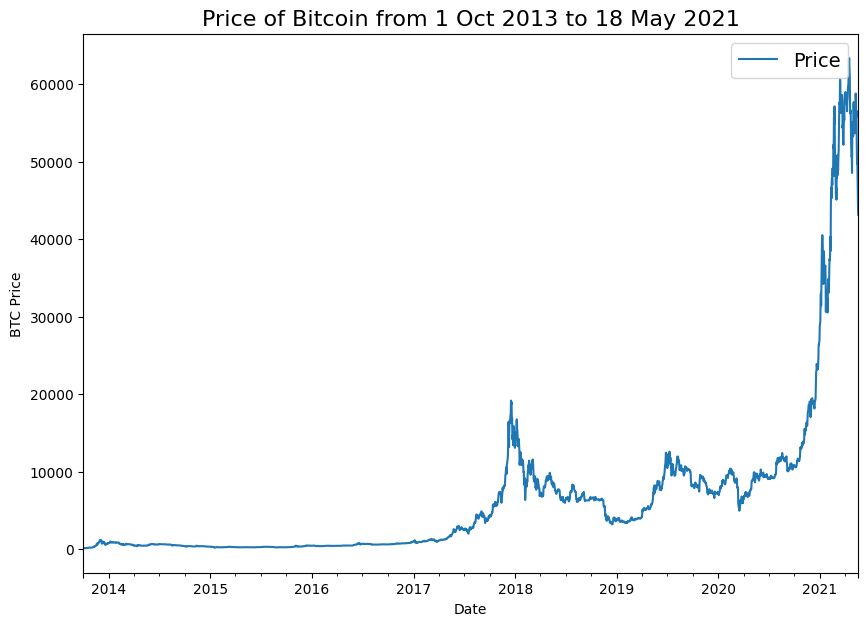

In [ ]:
# Plot everything in dataset
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [ ]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')  # read in the target CSV
    next(csv_reader)  # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))  # get the dates as dates (not strings), strptime = string parse time
        btc_price.append(float(line[2]))  # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0, 0.5, 'BTC Price')

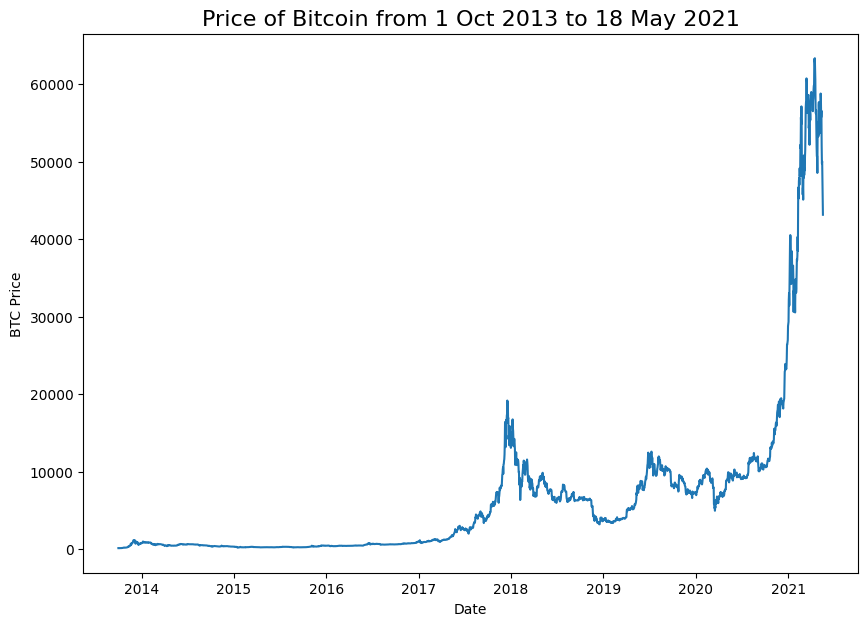

In [ ]:
# Plot from CSV
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price")

## Format Data Part 1: Creatining train and test sets for time series data

### Create train & test sets for time series (the wrong way)

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets fro time series
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,  # dates
                                                    prices,  # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

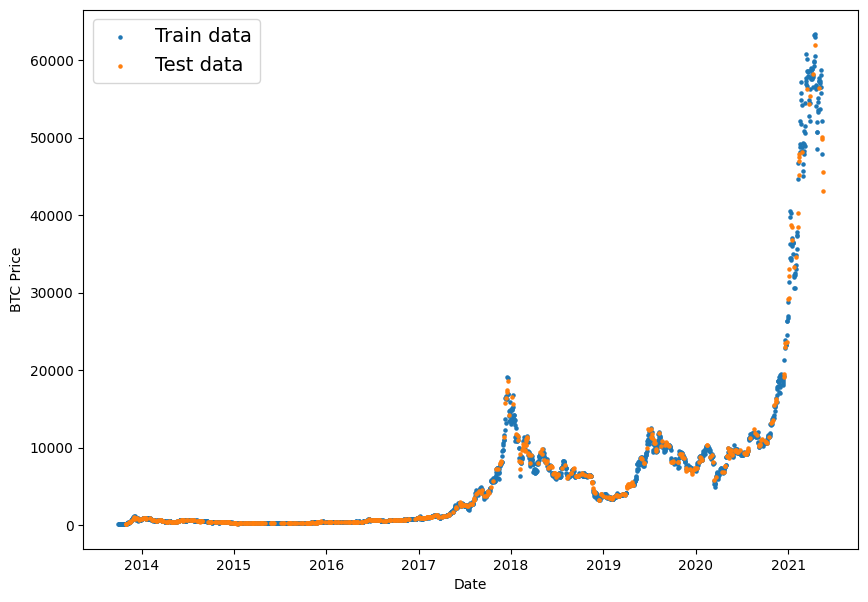

In [ ]:
# Let's plot wrong trian and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)

### Create train & test sets for time series (the right way)

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices))  # 80% trian, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

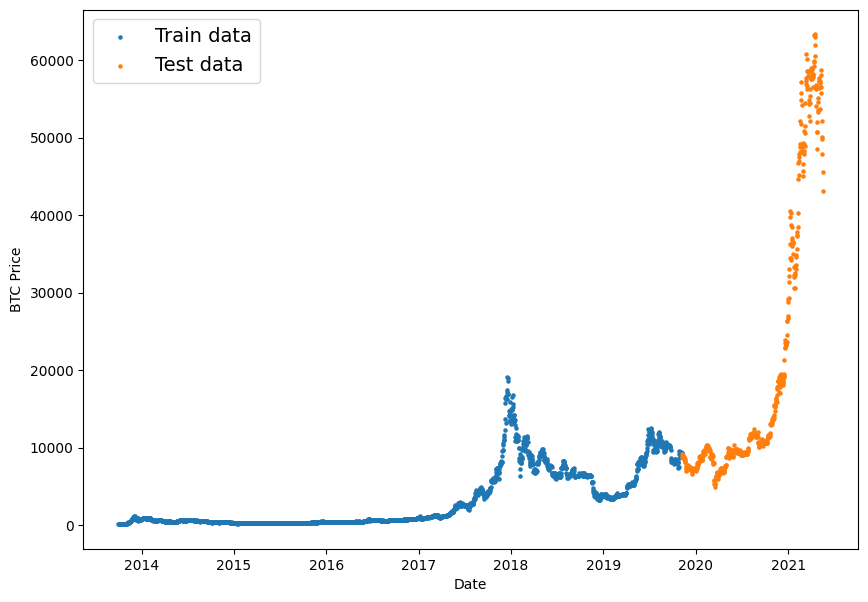

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)

#### Create a plotting function

In [69]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps);

    :param timesteps: array of timesteps;
    :param values: array of values across time;
    :param format: style of plot, default '.';
    :param start: where to start the plot (setting a value will index from start of timesteps & values);
    :param end: where to end the plot (setting a value will index from and of timesteps & values)
    :param label: label to show on plot of values.
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)  # make label bigger
    plt.grid(True)

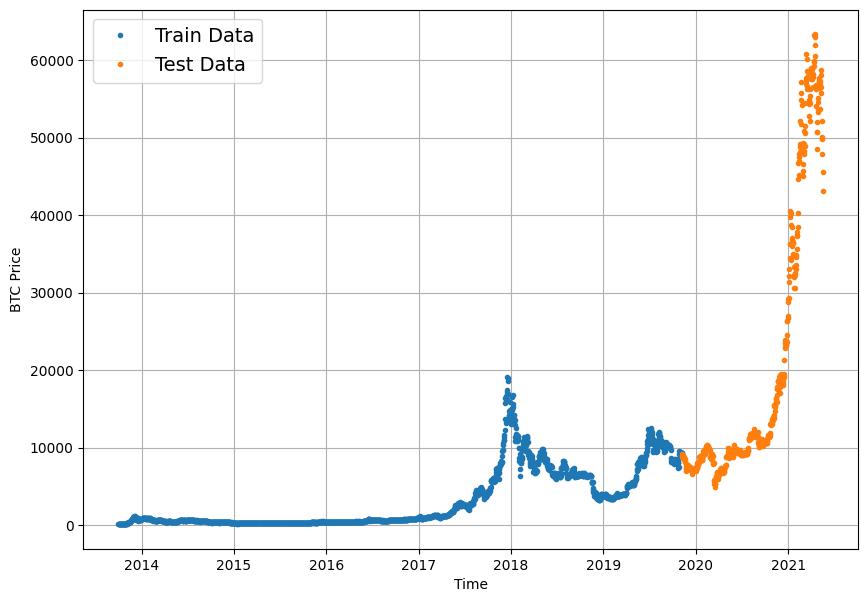

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

## Modelling Experiments

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ------------ | ---------- | --- | --- | --- |
| 0 |	Naïve model (baseline)|  NA          | NA          | NA |
| 1 |	Dense model           |	1            | 7           | NA |
| 2 |	Same as 1             | 1            | 30          | NA |
| 3 |	Same as 1             | 7            | 30          | NA |
| 4 |	Conv1D                |	1            |	7          | NA |
| 5 |	LSTM                  | 1            |	7          | NA |
| 6 |	Same as 1 (multivariate data) |	1    |	7          | Block reward size |
| 7 | N-BEATs Algorithm     |	1            |	7          | NA |
| 8 |	Ensemble (multiple modelsoptimized on different loss functions) |	1        |	7          | NA |
| 9 | Future prediction model (model to predict future values) |	1        |	7          | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1            |	7          | NA |

### Model 0: Naïve forecast (baseline)

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1]  # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:]  # View first 10  and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

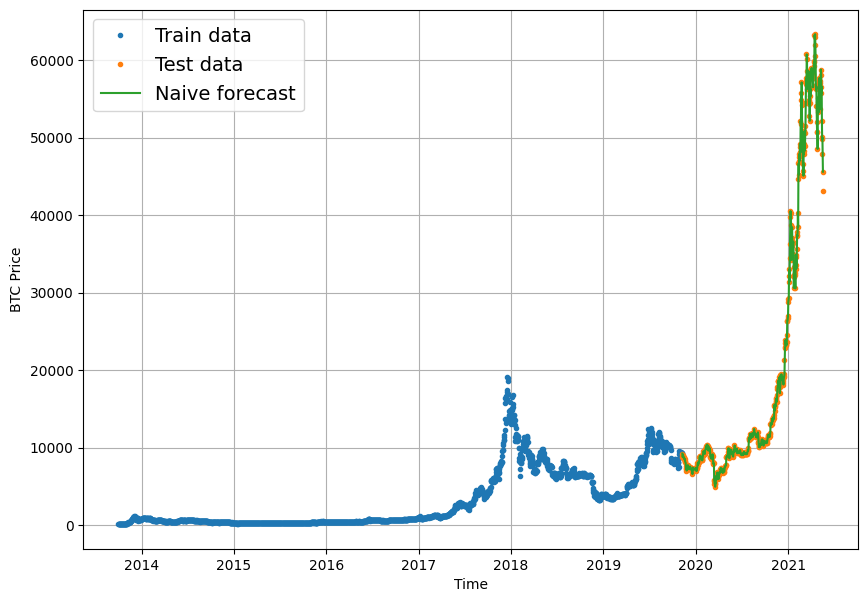

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label="Naive forecast")

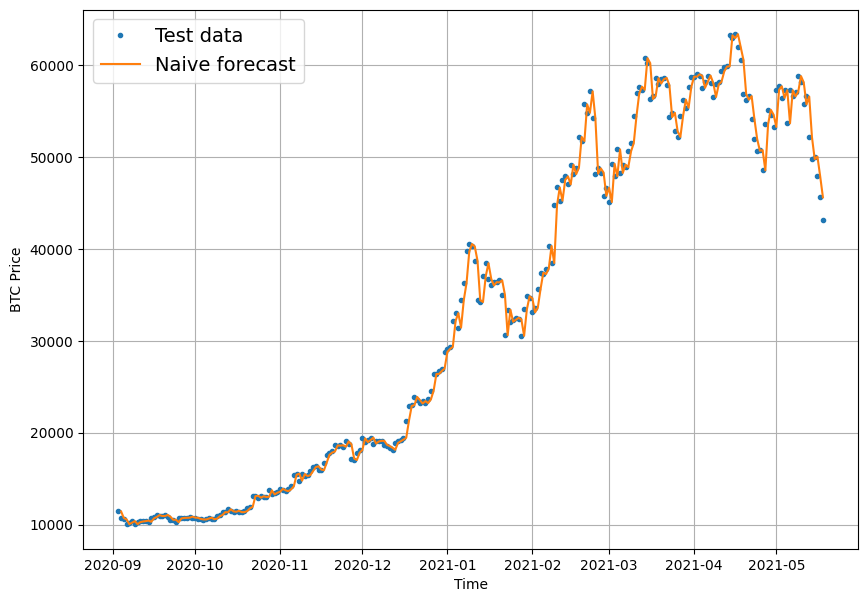

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300  # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', start=offset, label="Naive forecast")

## Evaluating a time series model

### Scale-dependent errors


| Metric | Details | Code |
| ------ | ------- | ---- |
| MAE (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt( tf.keras.metrics.mean_square_error() )` |

### Percentage errors

| Metric | Details | Code |
| ------ | ------- | ---- |
| MAPE (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | tf.keras.metrics.mean_absolute_percentage_error() |
| sMAPE (symmetric mean absolute percantage error) | Recommended not to be used by `Forecasting: Principles and Practice`, though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

| Metric | Details | Code |
| ------ | ------- | ---- |
| MASE (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's `mase_loss()` |

In [4]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data) with TensorFLow.
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))  # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season

In [5]:
def evaluate_predictions(y_true, y_pred):
    """
    Build dictionary with all metrics for our models to evaluate their performance
    """
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)  # puts and emphasis on outliers (all errorss get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy(),}

In [ ]:
naive_results = evaluate_predictions(y_true=y_test[1:],
                                     y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

### Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| Model/Library Name | Resource |
| ------------------ | -------- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

In [ ]:
HORIZON = 1  # predict 1 step at a time
WINDOW_SIZE = 7  # use a week worth of timesteps to predict the horizon

In [6]:
# Create function to label windowed data
def get_labelled_windows(X, horizon=1):
    """
    Creates labels for windowed dataset.
    E.g. if horizon=1 (default)
    then Input: [1, 2, 3, 4, 5, 6] --> Output: ([1, 2, 3, 4, 5], [6])
    """
    return X[:, :-horizon], X[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) + 1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} --> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] --> Label: 8


*Resource*: The fucntion created below has been adapted from Syafiq Kamarul Azman's article [Fast and Robust Sliding Window Vectorization with NumPy](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [7]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    # print(f"Window step:/n {window_step{}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T  # create 2D array of windows of size window_size
    # print(f"Window indexs:/n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} --> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] --> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] --> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} --> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] --> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] --> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] --> Label: [43144.47129086]


### Turning windows into training and test sets

In [8]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into trian and test splits.
    """
    split_size = int(len(windows) * (1 - test_split))  # this will default to 80% train/ 20% test

    train_windows = windows[:split_size]
    train_labels = labels[:split_size]

    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON - 1]), y_train[WINDOW_SIZE:])

True

## Make a modeling checkpoint

In [9]:
import os

# Create a function to implement a ModelCheckpoint callbac with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),  # create filepath to save model
                                              verbose=0,  # only output a limited amount of text
                                              save_best_only=True)  # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

In [ ]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear")  # linear activation is the same as having no activation
], name="model_1_dense")  # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=Adam(),
                metrics=["mae"])

In [ ]:
# Fit model
model_1.fit(x=train_windows,  # train windows of 7 timesteps of Bitcoin prices
            y=train_labels,  # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])  # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 2s 50ms/step - loss: 1991.7343 - mae: 1991.7343 - val_loss: 2821.5247 - val_mae: 2821.5247
Epoch 2/100
18/18 [==============================] - 1s 31ms/step - loss: 303.4752 - mae: 303.4752 - val_loss: 1220.7156 - val_mae: 1220.7156
Epoch 3/100
18/18 [==============================] - 1s 32ms/step - loss: 203.6059 - mae: 203.6059 - val_loss: 953.6566 - val_mae: 953.6566
Epoch 4/100
18/18 [==============================] - 1s 31ms/step - loss: 173.0194 - mae: 173.0194 - val_loss: 936.7548 - val_mae: 936.7548
Epoch 5/100
18/18 [==============================] - 1s 45ms/step - loss: 167.2684 - mae: 167.2684 - val_loss: 920.5402 - val_mae: 920.5402
Epoch 6/100
18/18 [==============================] - 1s 43ms/step - loss: 161.5276 - mae: 161.5276 - val_loss: 895.8907 - val_mae: 895.8907
Epoch 7/100
18/18 [==============================] - 1s 44ms/step - loss: 157.6038 - mae: 157.6038 - val_loss: 891.3176 - val_mae: 891.3176
Epoch 8/100
18

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 645.7145 - mae: 645.7145


[645.7145385742188, 645.7145385742188]

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 571.6485 - mae: 571.6485


[571.6484985351562, 571.6484985351562]

### Making forecasts with a model (on the test dataset)

In [10]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.

    :param model: trained model;
    :param input_data: windowed input data (same kind of data model was trained on);
    :return: model predictions on input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8862.093, 8766.142, 9022.081, 8778.077, 8737.83 , 8738.053,
        8693.57 , 8489.62 , 8473.504, 8513.403], dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_predictions(y_true=tf.squeeze(test_labels),  # reduce to right shape
                                       y_pred=model_1_preds)
model_1_results

{'mae': 571.6485,
 'mse': 1177253.8,
 'rmse': 1085.0132,
 'mape': 2.55696,
 'mase': 1.0042281}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

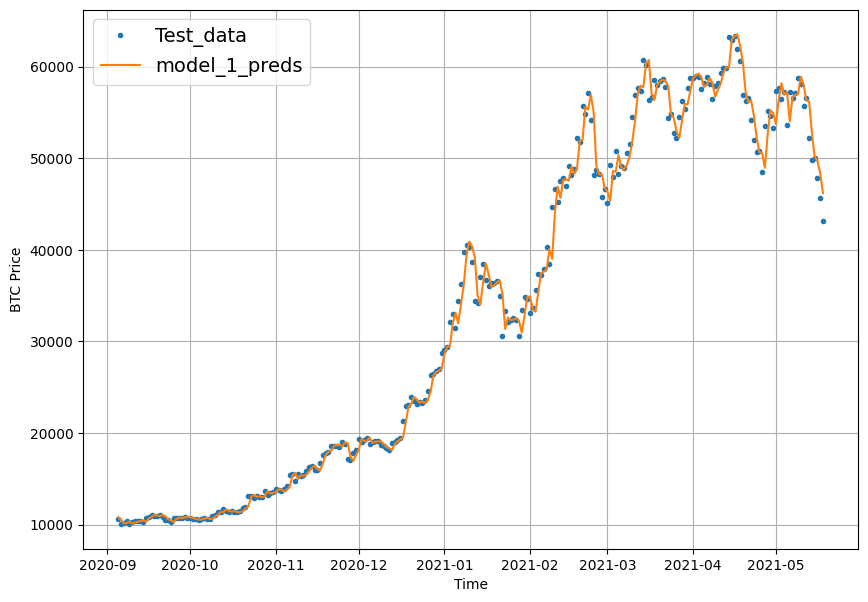

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON = 1  # predict one step at a time
WINDOW_SIZE = 30  # use 30 timesteps in the past

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

### Construct model_2

In [ ]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON)  # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 636.3557


636.355712890625

In [ ]:
# Load in best performing model
model_2 = load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 624.5558


624.5557861328125

In [ ]:
# Get forecast predicitons
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_predictions(y_true=tf.squeeze(test_labels),  # remove 1 dimentsion of test labels
                                       y_pred=model_2_preds)
model_2_results

{'mae': 624.55585,
 'mse': 1360790.2,
 'rmse': 1166.5292,
 'mape': 2.8183203,
 'mase': 1.0917298}

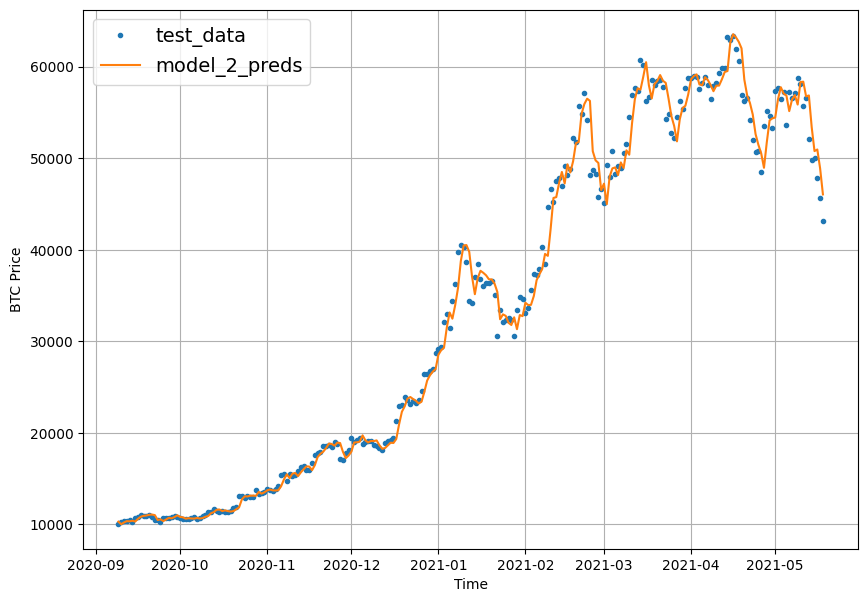

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# View how did our model with a larget window size and horizon go
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1276.6300


1276.6300048828125

In [ ]:
# Load in best version of model_3 and evaluate
model_3 = load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1212.7106


1212.7105712890625

In [ ]:
# The predicitons are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9246.21 , 9479.014, 9389.367, 9496.045, 9169.241, 9391.181,
        9331.98 ],
       [8955.406, 9075.811, 9117.887, 9313.551, 9095.419, 9104.918,
        8872.128],
       [8749.218, 8880.803, 8949.382, 9074.172, 9050.101, 8918.086,
        8840.826],
       [8858.809, 9006.849, 8944.57 , 9276.726, 9202.033, 9221.146,
        9153.989],
       [8775.677, 9033.119, 8842.225, 9029.979, 8894.902, 9001.719,
        9009.153]], dtype=float32)>

In [ ]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time
model_3_results = evaluate_predictions(y_true=tf.squeeze(test_labels),
                                       y_pred=model_3_preds)
model_3_results

{'mae': array([  564.3619  ,   326.72586 ,   313.78793 ,   468.28    ,
          386.61984 ,   469.4853  ,   535.1749  ,   459.87982 ,
          413.03836 ,   545.24066 ,   791.30585 ,   737.18146 ,
          744.4375  ,   877.4174  ,   597.7466  ,   244.0657  ,
          235.52051 ,   287.19888 ,   282.146   ,   291.76096 ,
          108.57457 ,   152.32436 ,   287.72858 ,   225.14285 ,
          166.23836 ,   141.80092 ,   107.459755,   172.45139 ,
          135.38176 ,   155.05539 ,   278.2913  ,   294.34814 ,
          260.31104 ,   292.42816 ,   249.88435 ,   309.33383 ,
          294.6901  ,   176.52344 ,   202.14006 ,   239.2523  ,
          580.02155 ,    91.91741 ,   105.56348 ,    81.92243 ,
           77.0256  ,    81.433174,   108.781044,   123.13261 ,
           56.199776,   147.56633 ,   129.64641 ,   124.13448 ,
          144.0641  ,   194.31676 ,   251.61942 ,   365.51508 ,
          609.2291  ,   546.61884 ,   477.30746 ,   606.49115 ,
          333.37912 ,   246.51877

## Make our evaluation function work for larger horizons

In [11]:
def evaluate_predictions(y_true, y_preds):

    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_preds = tf.cast(y_preds, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_preds)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_preds)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_preds)
    mase = mean_absolute_scaled_error(y_true, y_preds)

    # Account for different sized metrics (for larger horizons, reduce to single number)
    if mae.ndim > 0:  # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_predictions(y_true=tf.squeeze(test_labels),
                                       y_preds=model_3_preds)
model_3_results

{'mae': 1212.7106,
 'mse': 5228194.5,
 'rmse': 1400.8602,
 'mape': 5.412839,
 'mase': 2.1579506}

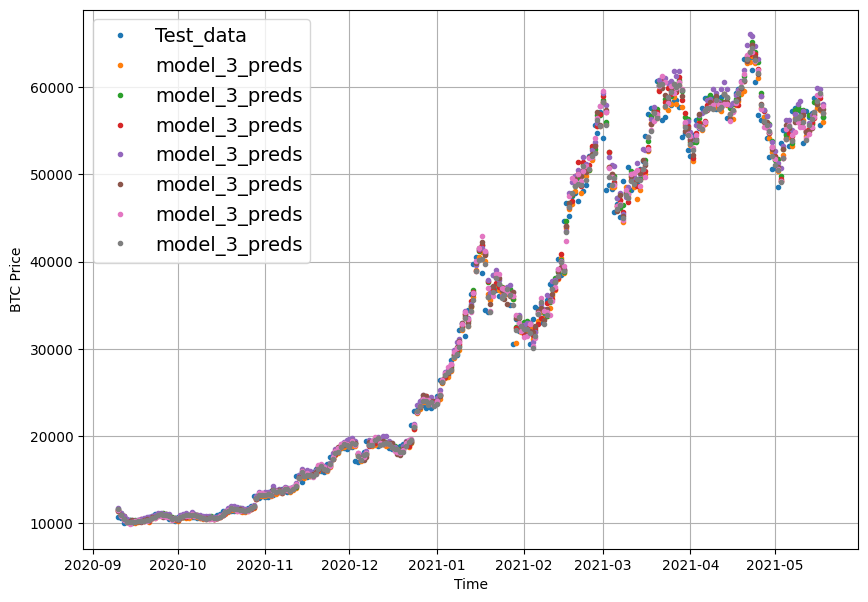

In [ ]:
# Visualize predictions
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

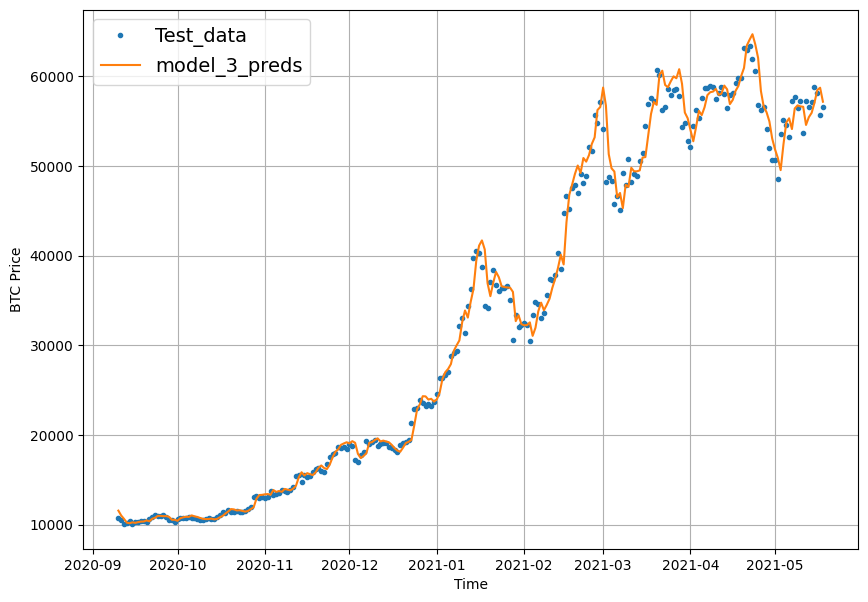

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Which of our models is performing best so far?

<Axes: >

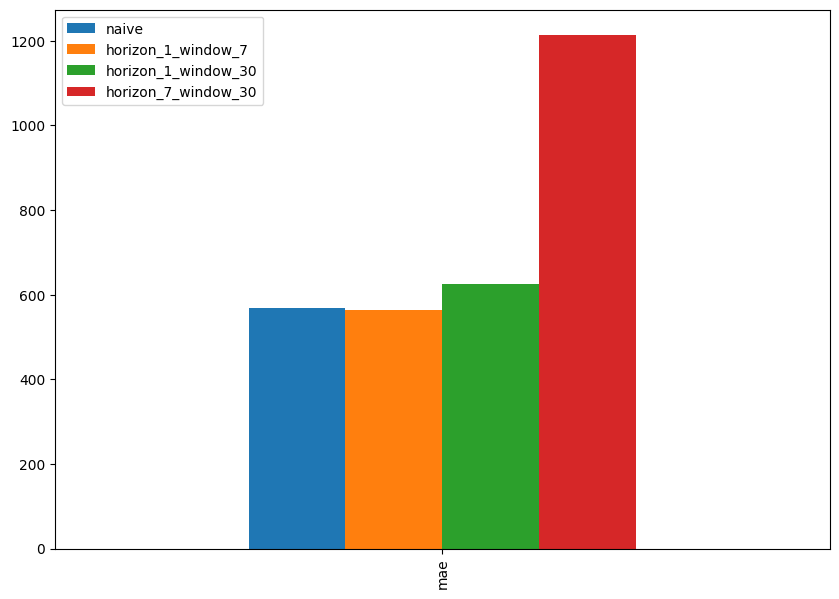

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

## Model 4: Conv1D

In [ ]:
HORIZON = 1  # predict next day
WINDOW_SIZE = 7  # use prevous week worth of data

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
# Check data sample shapes
train_windows[0].shape  # returns (WINDOW_SIZE, )

(7,)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = Lambda(lambda x: tf.expand_dims(x, axis=1))  # add on extra dimension for timesteps
print(f"Original shape: {x.shape}")  # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}")  # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape: \n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: 
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


### Construct Conv1D model

In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=1)),  # resize the inputs to adjust for window size / Conv1D 3D input requirements
    Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
# View what does the Lambda layer look like in a summary
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = load_model("model_experiments/model_4_conv1D/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 8ms/step - loss: 571.3097


571.3096923828125

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 6ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8901.555 , 8796.006 , 9002.524 , 8793.935 , 8752.163 , 8748.6455,
       8681.763 , 8547.886 , 8468.625 , 8522.63  ], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_predictions(y_true=tf.squeeze(test_labels),
                                       y_preds=model_4_preds)
model_4_results

{'mae': 571.3097,
 'mse': 1188736.1,
 'rmse': 1090.2917,
 'mape': 2.5743544,
 'mase': 1.0036329}

## Model 5: RNN (LSTM)

In [ ]:
# We reuse the same data we used for the Conv1D model
tf.random.set_seed(42)

# Let's build on LSTM model with the Functional API
inputs = Input(shape=(WINDOW_SIZE))
x = Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)  # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = LSTM(128, activation="relu", return_sequences=True)(x)  # this layer will error if the inputs are not the right shape
x = LSTM(128, activation="relu")(x)  # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = Dense(32, activation="relu")(x)
output = Dense(HORIZON)(x)
model_5 = Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 596.9167


596.9166870117188

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8926.379, 8789.239, 8931.618, 8772.059, 8725.097, 8715.018,
       8660.859, 8544.061, 8440.045, 8486.993], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_predictions(y_true=tf.squeeze(test_labels),
                                       y_preds=model_5_preds)
model_5_results

{'mae': 596.9167,
 'mse': 1261773.8,
 'rmse': 1123.287,
 'mape': 2.7011504,
 'mase': 1.0486172}

### Make a multivariate time series

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Block reward values
block_reward_1 = 50  # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25  # 28 November 2012
block_reward_3 = 12.5  # 9 Jupy 2016
block_reward_4 = 6.25  # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
# Get date indexes for when to add different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
# Add  block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block-reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<Axes: xlabel='Date'>

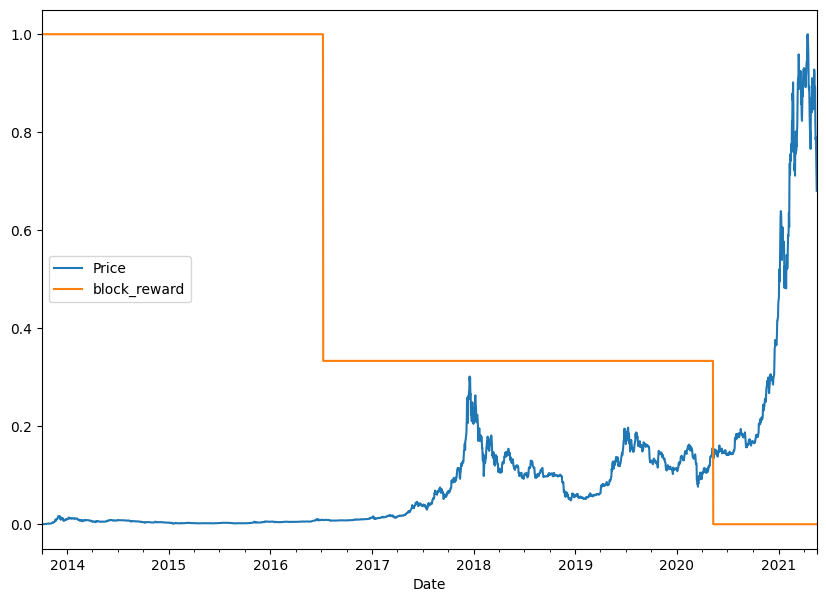

In [ ]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),  # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

### Making a windowed dataset with pandas

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):  # Shift values for each step in WINDOW_SIZE
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = Sequential([
    Dense(128, activation="relu"),
    # Dense(128, activation="relu"),  # adding on extra layer here should lead to beating the naive
    Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [ ]:
# Make sure best model is loaded and evaluate
model_6 = load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 571.6346


571.6345825195312

In [ ]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8869.561, 8746.035, 9014.056, 8815.014, 8709.976, 8732.345,
       8697.357, 8509.748, 8452.766, 8520.001], dtype=float32)>

In [ ]:
# Evaluate predictions
model_6_results = evaluate_predictions(y_true=y_test,
                                       y_preds=model_6_preds)
model_6_results

{'mae': 571.6346,
 'mse': 1180828.2,
 'rmse': 1086.6592,
 'mape': 2.5722919,
 'mase': 1.0042037}

In [ ]:
# View how do these results compare to model_1 (same window size and horizon but without the block reward feature)
model_1_results

{'mae': 563.4694,
 'mse': 1153296.2,
 'rmse': 1073.9163,
 'mape': 2.5285757,
 'mase': 0.9898597}

### Exercises
1. True adding an extra `keras.layers.Dense()` layer with 128 hidden units to model_6, how does this effect model performance?
2. Is there a better way to create this model? As in, should the `block_reward` feature be bundled in with the Bitcoin historical price feature? Perhaps you could test whether building a multi-input model (e.g. one model input for Bitcoin price history and one model input for `block_reward) works better?

#### Exercise - 1

In [ ]:
tf.random.set_seed(42)

model_6_1 = Sequential([
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(HORIZON)
], name="model_6_extndd_dense_multivariate")

# Compile
model_6_1.compile(loss="mae",
                optimizer=Adam())

In [ ]:
# Fit the model
model_6_1.fit(X_train, y_train,
              epochs=100,
              batch_size=128,
              verbose=0,
              validation_data=(X_test, y_test),
              callbacks=[create_model_checkpoint(model_name=model_6_1.name)])

In [ ]:
# Make sure best model is loaded and evaluate
model_6_1 = load_model("model_experiments/model_6_extndd_dense_multivariate")
model_6_1.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 568.5813


568.581298828125

In [ ]:
# Make predictions on multivariate data
model_6_1_preds = tf.squeeze(model_6_1.predict(X_test))
model_6_1_preds[:10]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8802.315, 8754.92 , 9055.316, 8759.673, 8724.607, 8737.081,
       8656.879, 8506.271, 8442.31 , 8526.622], dtype=float32)>

In [ ]:
# Evaluate predictions
model_6_1_results = evaluate_predictions(y_true=y_test,
                                         y_preds=model_6_1_preds)
model_6_1_results

{'mae': 568.5813,
 'mse': 1159775.8,
 'rmse': 1076.9288,
 'mape': 2.564081,
 'mase': 0.99883986}

In [ ]:
# View how do these results compare to model_1
model_1_results

{'mae': 563.4694,
 'mse': 1153296.2,
 'rmse': 1073.9163,
 'mape': 2.5285757,
 'mase': 0.9898597}

This model perform worth than model_6 and model_1, maybe because its overfiting on trained data with this additional Dense layer.

#### Exercise - 2

##### Prepare data

In [ ]:
# Let's create X & y for separate model (historical data & block_reward), remove the NaN's and convert to float 32 to prevent TensorFlow errors
history_X = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).astype(np.float32)
reward_X = bitcoin_prices_windowed.dropna().drop(["Price",
                                                  "Price+1",
                                                  "Price+2",
                                                  "Price+3",
                                                  "Price+4",
                                                  "Price+5",
                                                  "Price+6",
                                                  "Price+7"], axis=1).astype(np.float32)
hybrid_y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [ ]:
# View on separate data
history_X, reward_X

(                 Price+1       Price+2       Price+3       Price+4  \
 Date                                                                 
 2013-10-08    121.794998    120.655327    121.338661    118.674660   
 2013-10-09    123.032997    121.794998    120.655327    121.338661   
 2013-10-10    124.049004    123.032997    121.794998    120.655327   
 2013-10-11    125.961159    124.049004    123.032997    121.794998   
 2013-10-12    125.279663    125.961159    124.049004    123.032997   
 ...                  ...           ...           ...           ...   
 2021-05-14  52147.820312  56573.554688  55715.546875  58102.191406   
 2021-05-15  49764.132812  52147.820312  56573.554688  55715.546875   
 2021-05-16  50032.691406  49764.132812  52147.820312  56573.554688   
 2021-05-17  47885.625000  50032.691406  49764.132812  52147.820312   
 2021-05-18  45604.617188  47885.625000  50032.691406  49764.132812   
 
                  Price+5       Price+6       Price+7  
 Date              

In [ ]:
# Make train and test sets
split_size = int(len(history_X) * 0.8)
history_X_train, reward_X_train, hybrid_y_train = history_X[:split_size], reward_X[:split_size], hybrid_y[:split_size]
history_X_test, reward_X_test, hybrid_y_test = history_X[split_size:], reward_X[split_size:], hybrid_y[split_size:]
len(history_X_train), len(reward_X_train), len(hybrid_y_train), len(history_X_test), len(reward_X_test), len(hybrid_y_test)

(2224, 2224, 2224, 556, 556, 556)

In [ ]:
# Combine historical & block_reward data to one dataset but as separate input tensors
train_history_reward_data = tf.data.Dataset.from_tensor_slices((history_X_train.to_numpy(), reward_X_train.to_numpy()))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices(hybrid_y_train)
train_hybrid_dataset = tf.data.Dataset.zip((train_history_reward_data, train_hybrid_labels))

# Prefetch and batch train data
train_hybrid_dataset = train_hybrid_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

# Repeat same steps for test data
test_history_reward_data = tf.data.Dataset.from_tensor_slices((history_X_test, reward_X_test))
test_hybrid_labels = tf.data.Dataset.from_tensor_slices(hybrid_y_test)
test_hybrid_dataset = tf.data.Dataset.zip((test_history_reward_data, test_hybrid_labels))
test_hybrid_dataset = test_hybrid_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

##### Construct model

In [ ]:
# Build model_6 again with some difference in the input layer of the model
tf.random.set_seed(42)

# 1. Setup Bitcoin historical data input/model
history_inputs = Input(shape=(WINDOW_SIZE), name="historical_input")
history_dense = Dense(128, activation="relu")(history_inputs)
history_output = Dense(HORIZON)(history_dense)
history_model = Model(inputs=history_inputs,
                      outputs=history_output)

# 2. Setup Bitcoin block rewad data input/model
reward_inputs = Input(shape=(1,), name="reward_input")
reward_dense = Dense(128, activation="relu")(reward_inputs)
reward_output = Dense(HORIZON)(reward_dense)
reward_model = Model(inputs=reward_inputs,
                     outputs=reward_output)

# 3. Concatenate token and char inputs (create hybrid token embedding)
history_reward_concat = Concatenate(name="history_reward_hybrid_model")([history_model.output,
                                                                         reward_model.output])

# 4. Create output layers - addition of dropout
combined_dropout = Dropout(0.5)(history_reward_concat)
combined_dense = Dense(200, activation="relu")(combined_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(HORIZON)(final_dropout)

# 5. Construct model with bitcoin historical data and bitcoin block rewards inputs
model_6_2 = Model(inputs=[history_model.input, reward_model.input],
                  outputs=output_layer,
                  name="model_6_hybrid_dense_multivariate")

# Compile
model_6_2.compile(loss="mae",
                  optimizer=Adam())

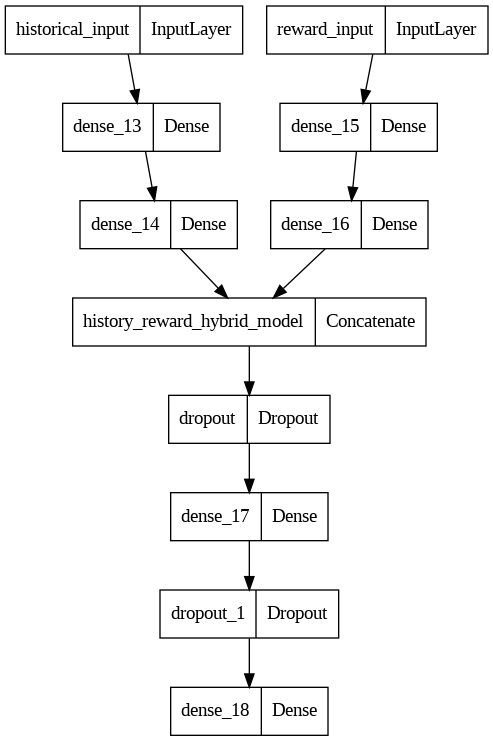

In [ ]:
# Plot hybrid model
plot_model(model_6_2)

In [ ]:
# Fit the model
model_6_2.fit(train_hybrid_dataset,
              epochs=100,
              batch_size=128,
              verbose=0,
              validation_data=test_hybrid_dataset,
              callbacks=[create_model_checkpoint(model_name=model_6_2.name)])

In [ ]:
# Make sure best model is loaded and evaluate
model_6_2 = load_model("model_experiments/model_6_hybrid_dense_multivariate")
model_6_2.evaluate(test_hybrid_dataset)

5/5 [==============================] - 0s 4ms/step - loss: 9654.7568


9654.7568359375

In [ ]:
# Make predictions on multivariate data
model_6_2_preds = tf.squeeze(model_6_2.predict(test_hybrid_dataset))
model_6_2_preds[:10]

5/5 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([4891.73  , 4839.8447, 4790.4395, 4797.071 , 4743.8457, 4660.545 ,
       4653.7915, 4636.263 , 4591.96  , 4547.1787], dtype=float32)>

In [ ]:
# Evaluate predictions
model_6_2_results = evaluate_predictions(y_true=hybrid_y_test,
                                         y_preds=model_6_2_preds)
model_6_2_results

{'mae': 9654.756,
 'mse': 165567540.0,
 'rmse': 12867.306,
 'mape': 47.757565,
 'mase': 16.960732}

In [ ]:
# View how do model_6_2 results compare to model_1, model_6, and model_6_1
print(model_1_results)
print(model_6_results)
print(model_6_1_results)

{'mae': 563.4694, 'mse': 1153296.2, 'rmse': 1073.9163, 'mape': 2.5285757, 'mase': 0.9898597}
{'mae': 571.6346, 'mse': 1180828.2, 'rmse': 1086.6592, 'mape': 2.5722919, 'mase': 1.0042037}
{'mae': 568.5813, 'mse': 1159775.8, 'rmse': 1076.9288, 'mape': 2.564081, 'mase': 0.99883986}


This model_6_2 performs poorly, and model_6 now serves to perform best among all models.

## Model 7: N-BEATS algorithm
we're going to focus on:
1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)
![](https://camo.githubusercontent.com/4a9606f328443804f3e0eb99a881b54dadbb081ea2ec2335d1f20949b68c519d/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f31302d6669677572652d312d6e62656174732d70617065722d616e6e6f74617465642e706e67)

2. Using the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

Doing this will give us an opportunity to practice:
- Creating a custom layer for the NBeatsBlock by subclassing tf.keras.layers.Layer
    * Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)
- Implementing a custom architecture using the Functional API
- Finding a paper related to our problem and seeing how it goes

In [ ]:
# Create NBeatsBlock custom layer
class NBeatsBlock(Layer):

    def __init__(self,  # the constructor takes all the hyperparameters for the layer
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs):  # the **kwargs argument takes core of all of the arguments for the parent class
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each haas ReLU activation
        self.hidden = [Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        # Output of block is a theta layerwith linear activation
        self.theta_layer = Dense(theta_size, activation="linear", name="theta")


    def call(self, inputs):

        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,  # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)  # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.20116317  0.18937644 -0.36124584 -0.43780008 -1.024563   -0.8053432
  0.56298506]
Forecast: -0.4155239462852478


### Preparing data for the N-BEATS algorithm using tf.data

In [ ]:
HORIZON = 1  # how for to predict forward
WINDOW_SIZE = 7  # how for to lookback

In [ ]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024  # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

Table 18/Appendix D
![](https://camo.githubusercontent.com/8cfd3469b4fc083f3f8375726d64b5afc800b7c0f393b91648558c0cfa5d1dcf/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f31302d6e62656174732d7461626c652d31382d6879706572706172616d65746572732e706e67)

In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000  # called "Iterations" in Table 18
N_NEURONS = 512  # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON  # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

They're what make N-BEATS double residual stacking (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:

- `tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other
- `tf.keras.layers.add(inputs)` - adds list of input tensors to each other


In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = subtract([tensor_1, tensor_2])

# Add
added = add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS - 1)):  # first stack is already created in (3)

    # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals)  # pass it in residuals (the backcast)

    # 6. Create the double residual stacking
    residuals = subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = Model(inputs=stack_input,
                outputs=forecast,
                name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=Adam(0.001),
                metrics=["mae", "mse"])

CPU times: user 2.8 s, sys: 28.7 ms, total: 2.83 s
Wall time: 2.81 s


In [ ]:
# 8.1 Create callbacks
callbacks = [EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
             ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)]

In [ ]:
# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,  # prevent large amounts of training outputs
            # callbacks = [create_model_checkpoint(model_name=model_7.name)]  # saving movel every epoch
            callbacks=callbacks)


Epoch 233: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 333: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 28ms/step - loss: 581.2641 - mae: 581.2641 - mse: 1173028.8750


[581.2640991210938, 581.2640991210938, 1173028.875]

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8886.191, 8799.479, 9003.541, 8727.432, 8757.148, 8778.277,
       8653.34 , 8510.189, 8502.548, 8518.179], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_predictions(y_true=y_test,
                                       y_preds=model_7_preds)
model_7_results

{'mae': 581.2641,
 'mse': 1173028.9,
 'rmse': 1083.0646,
 'mape': 2.6585286,
 'mase': 1.0211201}

### Plotting the N-BEATS architecture we've created

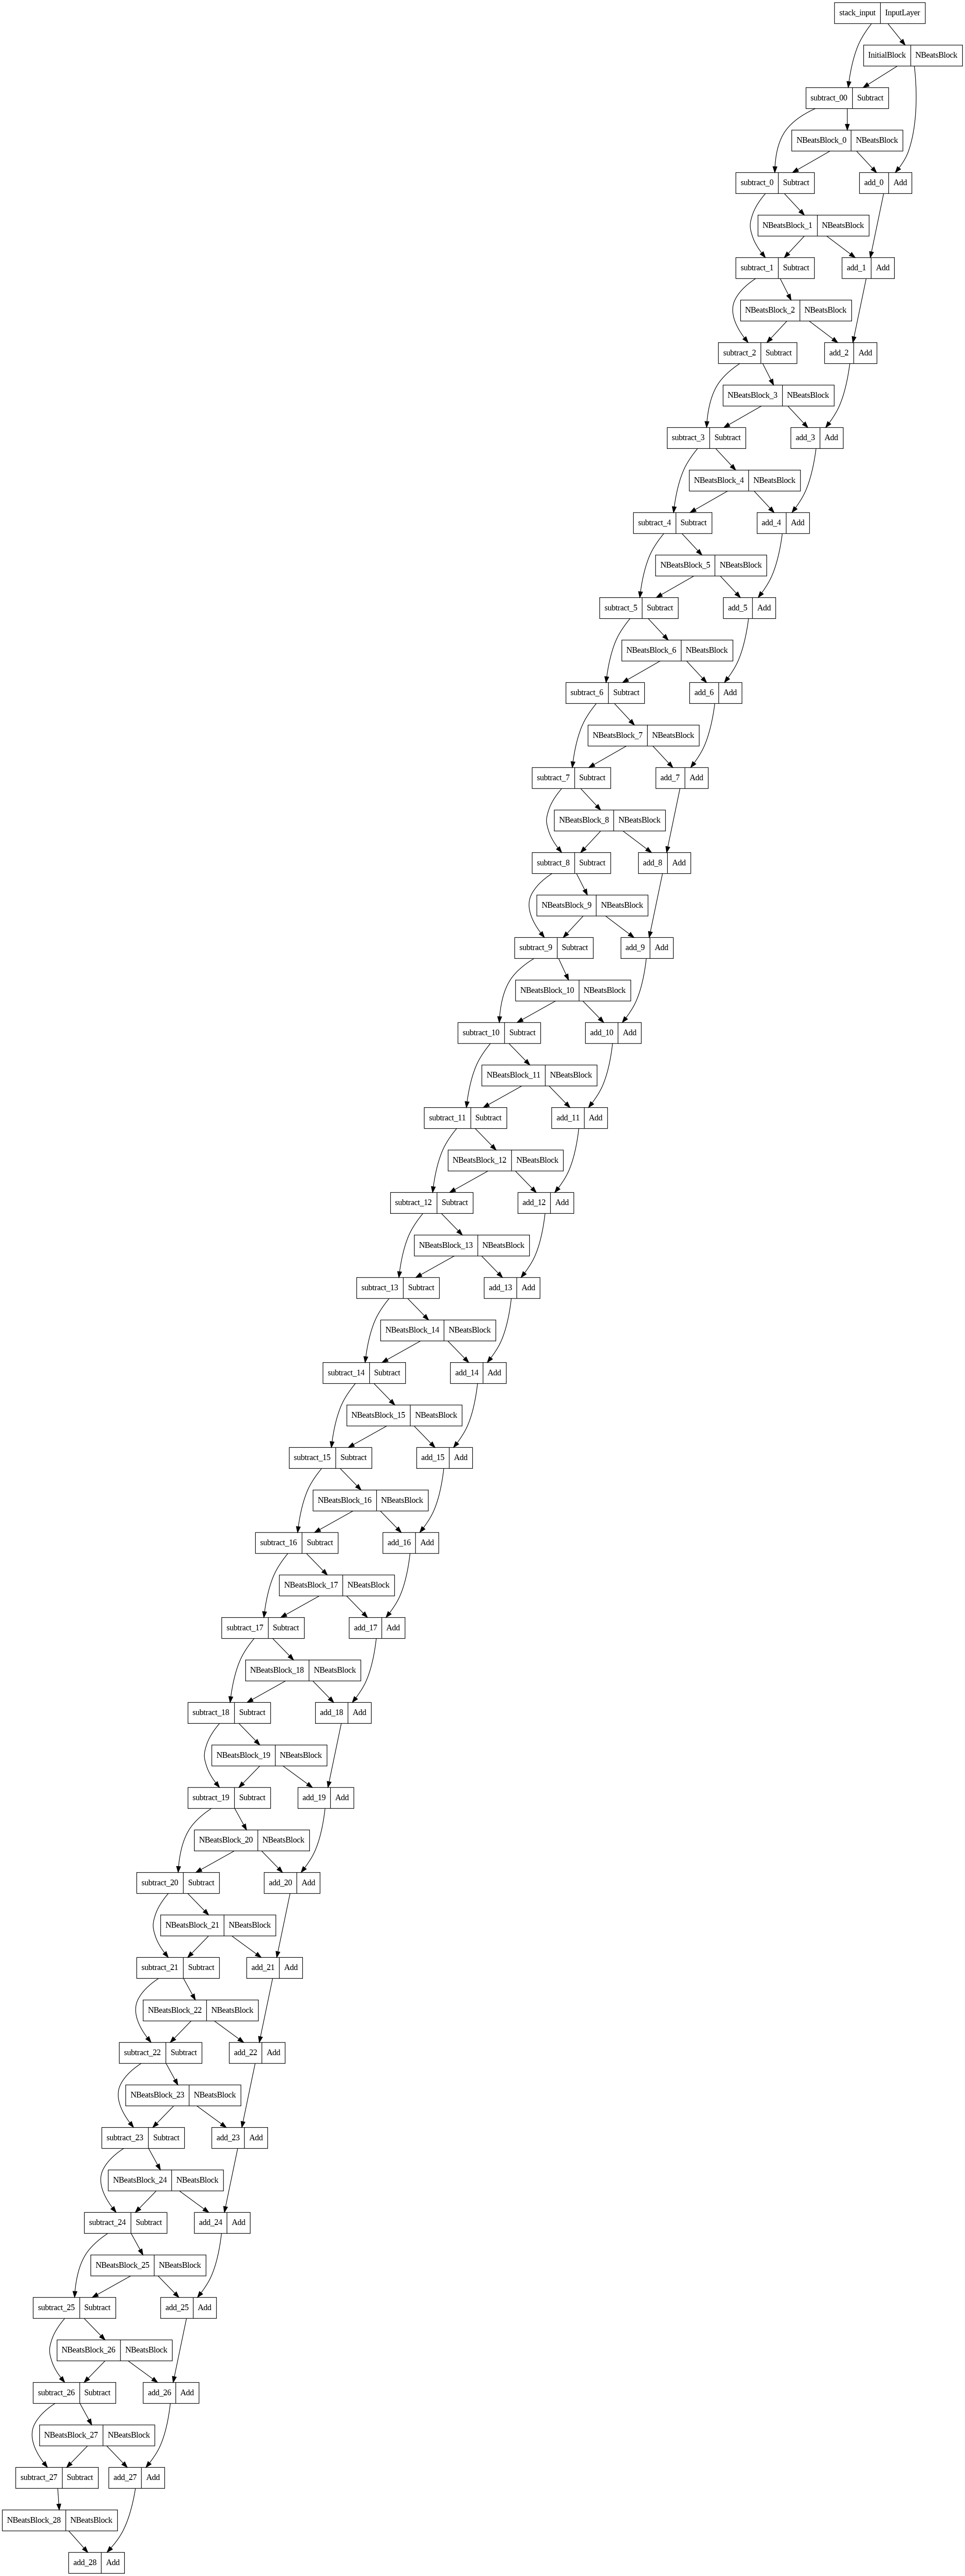

In [ ]:
# Plot the N-BEATS model and inspect the architecture
plot_model(model_7)

In [ ]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

## Model 8: Creating an ensemble (stacking different models together)

To create our ensemble models we're going to be using a combination of:

- Different loss functions (MAE, MSE, MAPE)
- Randomly initialized models


### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                       train_data=train_dataset,
                       test_data=test_dataset,
                       num_iter=10,
                       num_epochs=100,
                       loss_fns=["mae", "mse", "mape"]):
    """
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

    For example, if num_iter=10, a list of 30 trined models will be returned:
    10 * len(["mae", "mse", "mape"]).
    """
    # Make empty list for trained ensemble models
    ensemble_models = []

    # Create num_iter number of models per loss function
    for i in range(num_iter):
        # Build and fit a new model with a different loss function
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

            # Construct a simple model (similar to model_1)
            model = Sequential([
                # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
                # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
                Dense(128, kernel_initializer="he_normal", activation="relu"),
                Dense(128, kernel_initializer="he_normal", activation="relu"),
                Dense(HORIZON)
            ])

            # Compile simple model with current loss function
            model.compile(loss=loss_function,
                          optimizer=Adam(),
                          metrics=["mae", "mse"])

            # Fit model
            model.fit(train_data,
                      epochs=num_epochs,
                      verbose=0,
                      validation_data=test_data,
                      # Add callbacks to prevent training from going/stalling for too long
                      callbacks=[EarlyStopping(monitor="val_loss",
                                               patience=200,
                                               restore_best_weights=True),
                                 ReduceLROnPlateau(monitor="val_loss",
                                                   patience=100,
                                                   verbose=1)])

            # Append fitted model to list of ensemble models
            ensemble_models.append(model)

    return ensemble_models  # return list of trained models

In [ ]:
%%time
# Get list of tained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 165: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 957: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 633: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 733: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 196: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 296: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 231: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 331: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 733: ReduceLROnPl

### Making predictions with an ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)  # make predictions with current ensemble model
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 49ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8811.794,  8803.696,  9058.081, ..., 50508.035, 48451.367,
        46411.57 ],
       [ 8824.232,  8779.109,  9050.844, ..., 50075.434, 48056.58 ,
        46493.79 ],
       [ 8813.237,  8759.147,  9084.036, ..., 50389.387, 48316.652,
        45968.98 ],
       ...,
       [ 8749.185,  8860.64 ,  9065.73 , ..., 49371.516, 48794.492,
        46061.62 ],
       [ 8790.649,  8820.722,  9052.546, ..., 49728.88 , 48558.375,
        46928.133],
       [ 8808.607,  8804.625,  9057.186, ..., 50711.535, 48504.105,
        47050.207]], dtype=float32)>

In [ ]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_predictions(y_true=y_test,
                                        y_preds=np.median(ensemble_preds, axis=0))  # take the median across all ensemble predictions
ensemble_results

{'mae': 566.1043,
 'mse': 1147935.6,
 'rmse': 1071.4176,
 'mape': 2.568457,
 'mase': 0.9944885}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

In [38]:
# Find upper and lower bounds of ensemble predictions
def get_lower_upper(preds):  # 1. Take the predictions of multiple randomly initialized deep learning neural networks

    # 2. Measure the standard deviation of the predictions
    std = tf.math.reduce_std(preds, axis=0)

    # 3. Multiply the standard deviation by 1.96
    interval = 1.96 * std  # https://en.wikipedia.org/wiki/1.96

    # 4. Get the prediction interval upper and lower bounds
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval

    return lower, upper

In [ ]:
# Get the lower and upper bounds of the 95%
lower, upper = get_lower_upper(preds=ensemble_preds)

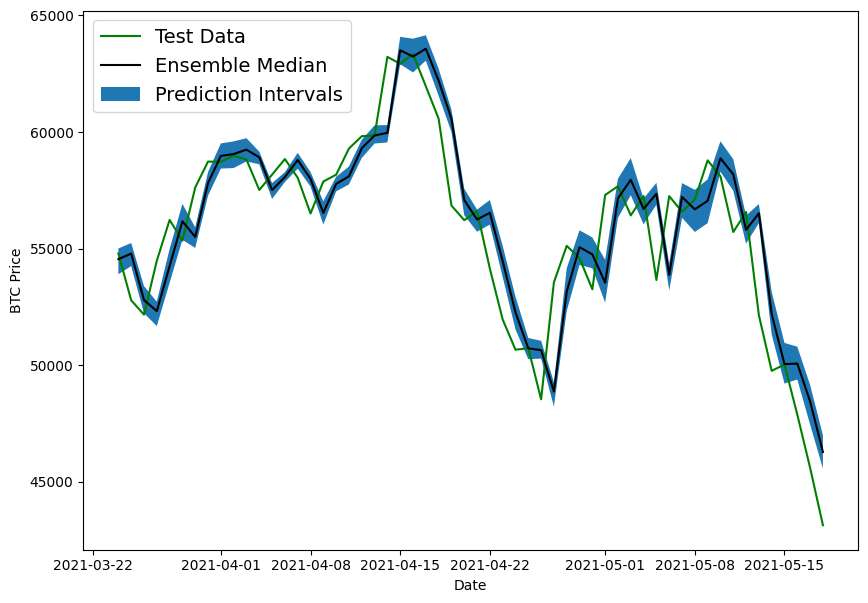

In [ ]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset = 500
plt.figure(figsize=(10, 7))

plt.plot(X_test.index[offset:], y_test[offset:], 'g', label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], 'k-', label="Ensemble Median")

plt.xlabel("Date")
plt.ylabel("BTC Price")

plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)

## Model 9: Train a model on the full historical data to make predictions into future

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()  # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [ ]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024  # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
from keras.losses import mae

tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = Sequential([
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(HORIZON)
])

# Compile
model_9.compile(loss=mae,
                optimizer=Adam())

In [ ]:
# Fit the model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)  # don't print out anything, we've seen this all before

### Make predictions on the future

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14  # since our Bitcoin data is daily, this is for 14 days

In [ ]:
# 1. Createa function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
    """
    Makes future forecasts into_future steps aftre values ends.

    Returns future forecasts as list of floats.
    """
    # 2. Make an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-window_size:]  # only want preds from the last window (this will get updated)

    # 3. Make INTO_FUTURE number of predictions, altering the ata which gets predicted on each time
    for _ in range(into_future):

        # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        # Append predictions to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())
        # print(future_forecast)

        last_window_data = tf.data.Dataset.from_tensor_slices(tf.expand_dims(last_window, axis=0))
        future_pred_data = tf.data.Dataset.from_tensor_slices(future_pred)

        data_for_training = tf.data.Dataset.zip((last_window_data, future_pred_data))

        data_for_training = data_for_training.batch(1).prefetch(tf.data.AUTOTUNE)

        # Exercise for retrain model after prediction
        model.fit(data_for_training,
                  epochs=1,
                  verbose=0)

        # Update last window with new pred and get window_size most recent preds (model was trained on window_size windows)
        last_window = np.append(last_window, future_pred)[-window_size:]

    return future_forecast

In [ ]:
# Make forecasts into future of the price of Bitcoin
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 226ms/step
Predicting on 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 51187.4765625

1/1 [==============================] - 0s 225ms/step
Predicting on 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 51187.4765625 ] -> Prediction: 46536.90625

1/1 [==============================] - 0s 70ms/step
Predicting on 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 51187.4765625  46536.90625   ] -> Prediction: 45120.796875

1/1 [==============================] - 0s 142ms/step
Predicting on 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 51187.4765625  46536.90625    45120.796875  ] -> Prediction: 43657.61328125

1/1 [==============================] - 0s 109ms/step
Predicting on 
 [47885.62525472 45604.61575361 43144.47129086 51187.4765625
 46536.90625    45120.796875   43657.61328125]

In [ ]:
# Let see on future forecast
future_forecast[:10]

[51187.477,
 46536.906,
 45120.797,
 43657.613,
 43090.37,
 40767.43,
 41334.574,
 44991.23,
 41114.45,
 39747.137]

### Plot future forecasts

In [35]:
def get_future_dates(start_date, into_future, offset=1):
    """
    Returns array of datetime values from ranging from start_date to start_date + horizon.

    :param start_date: data to start range (np.datatime64);
    :param into_future: number of days to add onto start date for range (int);
    :param offset: number of days to offset start_date by (default 1);
    :return: a date range between start date and end date.
    """
    start_date = start_date + np.timedelta64(offset, 'D')  # specify start date, "D" stands for day
    end_date = start_date + np.timedelta64(into_future, 'D')  # specify end date

    return np.arange(start_date, end_date, dtype="datetime64[D]")

In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 51187.477, 46536.906, 45120.797, 43657.613, 43090.37 ,
        40767.43 , 41334.574, 44991.23 , 41114.45 , 39747.137, 38408.605,
        38398.5  , 36827.25 , 38101.43 ], dtype=float32))

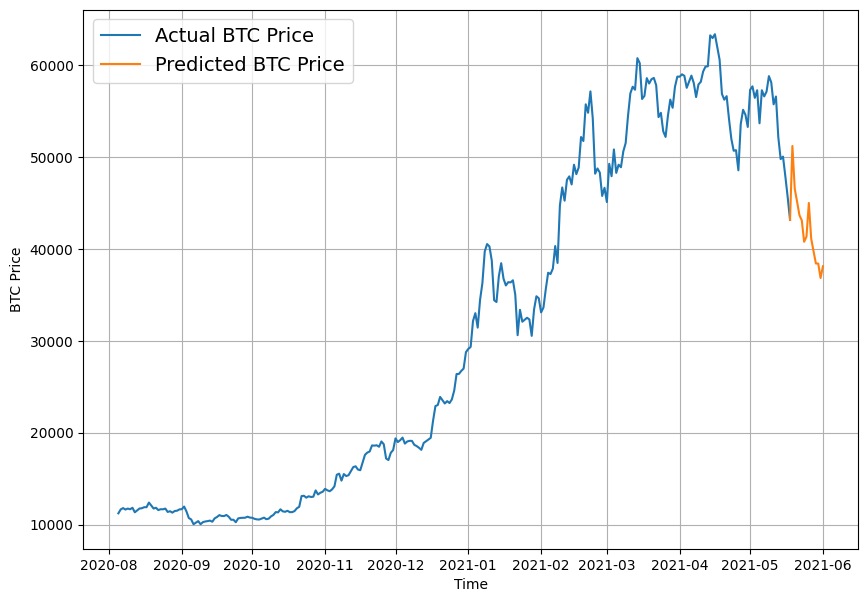

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format='-', label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format='-', label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem 🦃)

In [ ]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

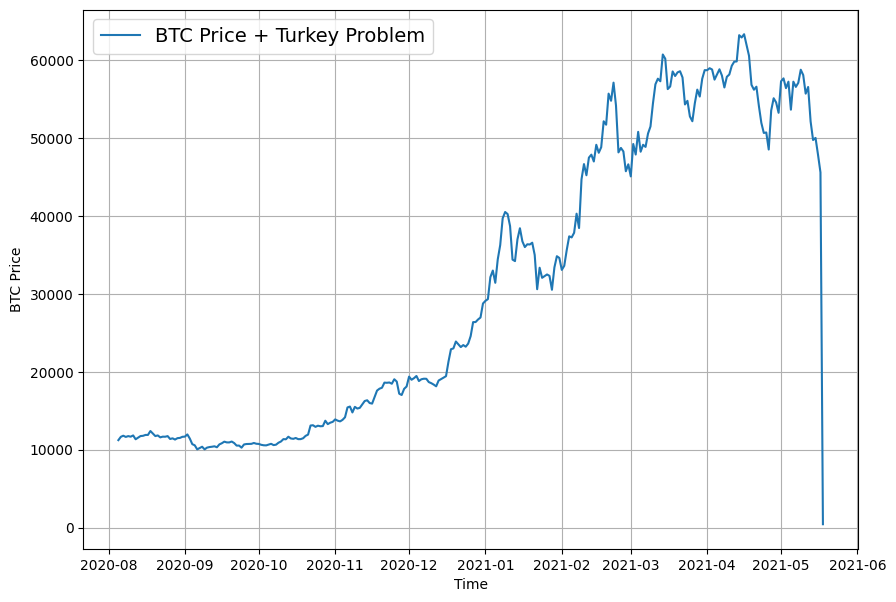

In [ ]:
# Plot our artificially created turkey problem Bitcoin data
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format='-',
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Building a turkey model (model to predict on turkey data)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = clone_model(model_1)
turkey_model._name = "Turkey_model"
turkey_model.compile(loss="mae",
                     optimizer=Adam())

In [ ]:
# Fit the model
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [ ]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 719.8591


719.859130859375

In [ ]:
# Load best model and evaluate on test data
turkey_model = load_model("model_experiments/Turkey_model")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 643.1403


643.1403198242188

In [ ]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8833.275 , 8754.714 , 9018.208 , 8762.447 , 8703.8955, 8721.606 ,
       8665.241 , 8511.418 , 8419.419 , 8508.601 ], dtype=float32)>

In [ ]:
# Evaluate turkey predictions
turkey_results = evaluate_predictions(y_true=y_test,
                                      y_preds=turkey_preds)
turkey_results

{'mae': 17135.264,
 'mse': 614852160.0,
 'rmse': 23724.855,
 'mape': 121.42334,
 'mase': 26.516876}

In [ ]:
# View on model 1 results
model_1_results

{'mae': 563.4694,
 'mse': 1153296.2,
 'rmse': 1073.9163,
 'mape': 2.5285757,
 'mase': 0.9898597}

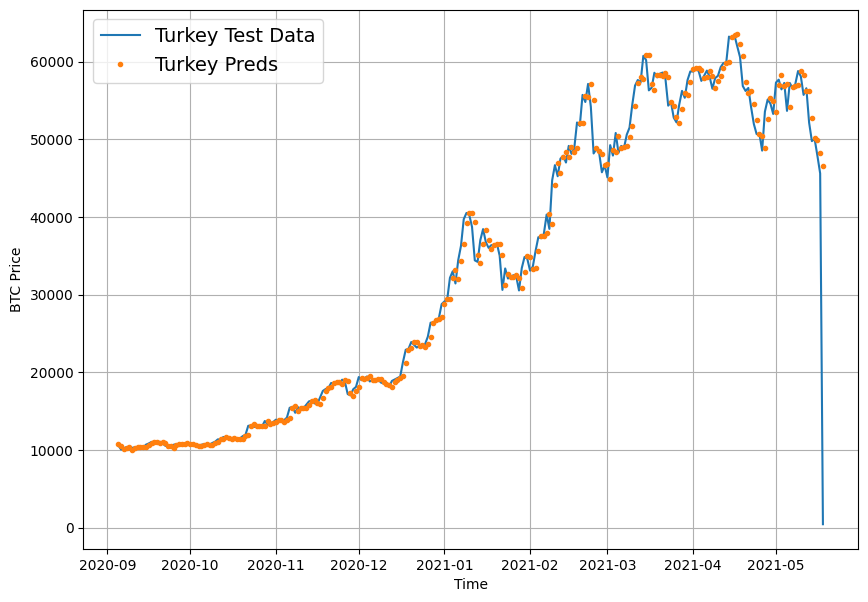

In [ ]:
# Visualize the turkey predictions over the test turkey data
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:splits], label="Train Data")
offset = 300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format='-',
                 label="Turkey Test Data", start=offset)

plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset)

## Compare Models

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_Conv1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,563.469421,1.153296e+06,1073.916260,2.528576,0.989860
model_2_dense_w30_h1,624.555847,1.360790e+06,1166.529175,2.818320,1.091730
model_3_dense_w30_h7,1212.710571,5.228194e+06,1400.860229,5.412839,2.157951
model_4_Conv1D,571.309692,1.188736e+06,1090.291748,2.574354,1.003633
model_5_LSTM,596.916687,1.261774e+06,1123.286987,2.701150,1.048617
model_6_multivariate,571.634583,1.180828e+06,1086.659180,2.572292,1.004204
model_7_NBEATS,581.264099,1.173029e+06,1083.064575,2.658529,1.021120
model_8_ensemble,566.104309,1.147936e+06,1071.417603,2.568457,0.994488
model_10_turkey,17135.263672,6.148522e+08,23724.855469,121.423340,26.516876


<Axes: >

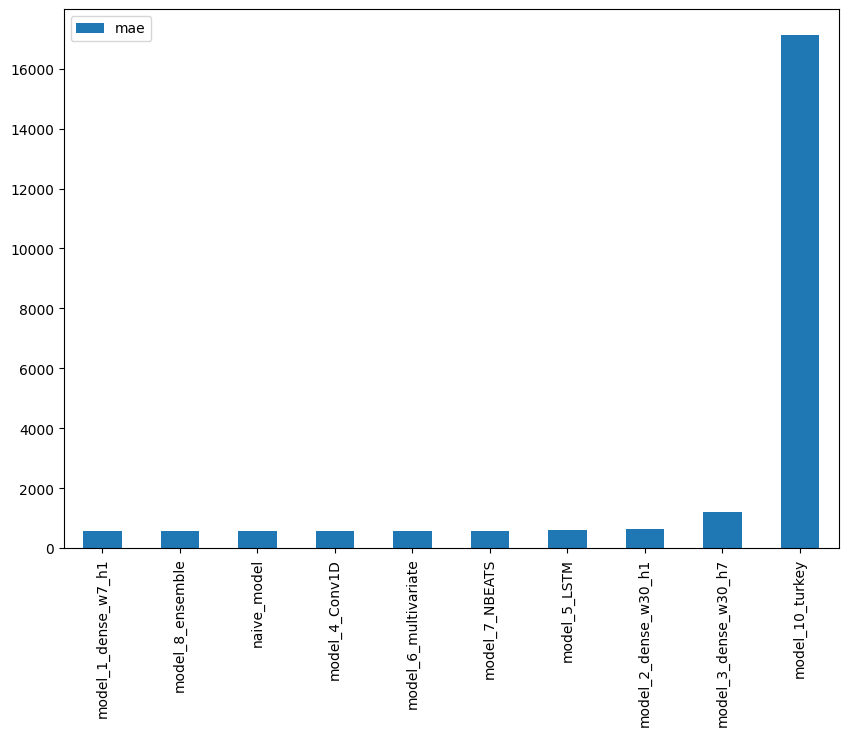

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar")

## Exercises

1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)

- Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.

2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).

- You can download the Bitcoin historical data for free from [coindesk.com/price/bitcoin](https://www.coindesk.com/price/bitcoin) and clicking "Export Data" -> "CSV".

3. For most of our models we used WINDOW_SIZE=7, but is there a better window size?

- Setup a series of experiments to find whether or not there's a better window size.
- For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.

4. Create a windowed dataset just like the ones we used for model_1 using tf.keras.preprocessing.timeseries_dataset_from_array() and retrain model_1 using the recreated dataset.
5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.

- Are there any other features you think you could add?
- If so, try it out, how do these affect the model?

6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.
7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn't retrained for every forecast (model_9)?
8. Throughout this notebook, we've only tried algorithms we've handcrafted ourselves. But it's worth seeing how a purpose built forecasting algorithm goes.

- Try out one of the extra algorithms listed in the modelling experiments part such as:
    * [Facebook's Kats library](https://github.com/facebookresearch/Kats) - there are many models in here, remember the machine learning practioner's motto: experiment, experiment, experiment.
    * [LinkedIn's Greykite library](https://github.com/linkedin/greykite)

### Exercise - 1

#### model_1 experiment

In [ ]:
# Set hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Scale data
scaled_prices_df = pd.DataFrame(minmax_scale(bitcoin_prices),  # we need to scale the data first
                                             columns=bitcoin_prices.columns,
                                             index=bitcoin_prices.index)
scaled_prices_df.head()

,Price
Date,
2013-10-01,0.000238
2013-10-02,0.000267
2013-10-03,0.000000
2013-10-04,0.000160
2013-10-05,0.000202


In [ ]:
# View on min/max value in dataset
scaled_prices_df.min(), scaled_prices_df.max()

(Price    0.0
 dtype: float64,
 Price    1.0
 dtype: float64)

<Axes: xlabel='Date'>

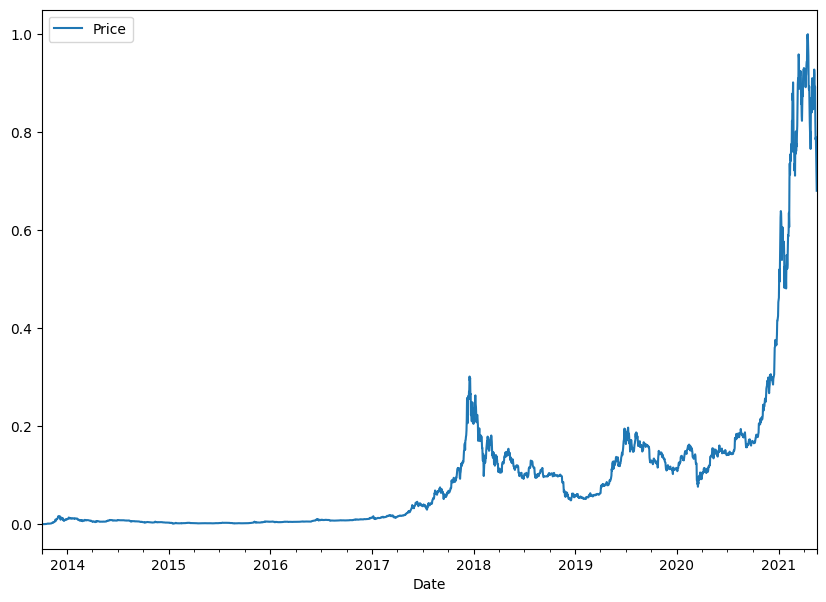

In [ ]:
# Visualize scaled data
scaled_prices_df.plot(figsize=(10, 7))

In [ ]:
full_windows, full_labels = make_windows(scaled_prices_df["Price"].to_numpy(), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [ ]:
ex_1_model_1 = clone_model(model_1)
ex_1_model_1._name = "ex_1_model_1"
ex_1_model_1.compile(loss="mae",
                     optimizer=Adam())

In [ ]:
# Fit the model
ex_1_model_1.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(ex_1_model_1.name)])

In [ ]:
# Evaluate model
ex_1_model_1.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 0.0122


0.012246038764715195

In [ ]:
# Load best model and evaluate
ex_1_model_1 = load_model("model_experiments/ex_1_model_1/")
ex_1_model_1.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 0.0091


0.009133810177445412

In [ ]:
# Make predictions
ex_1_model_1_preds = make_preds(ex_1_model_1, X_test)

18/18 [==============================] - 0s 2ms/step


In [ ]:
# Evaluate predictions
ex_1_model_1_results = evaluate_predictions(y_test, ex_1_model_1_preds)
ex_1_model_1_results

{'mae': 0.2704746,
 'mse': 0.15296392,
 'rmse': 0.3740274,
 'mape': 114.28954,
 'mase': 30.047562}

In [ ]:
# View on previous results with this model but with another data
model_1_results

{'mae': 563.4694,
 'mse': 1153296.2,
 'rmse': 1073.9163,
 'mape': 2.5285757,
 'mase': 0.9898597}

#### model_6 experiment

In [ ]:
# Scale data
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),  # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
# View on min/max value in dataset
scaled_price_block_df.min(), scaled_price_block_df.max()

(Price           0.0
 block_reward    0.0
 dtype: float64,
 Price           1.0
 block_reward    1.0
 dtype: float64)

<Axes: xlabel='Date'>

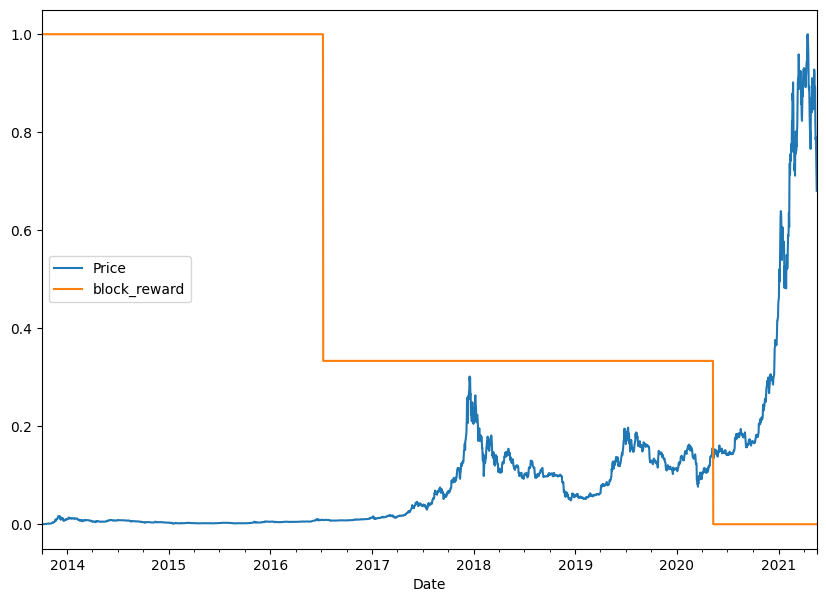

In [ ]:
# Visualize scaled data
scaled_price_block_df.plot(figsize=(10, 7))

In [ ]:
# Add windowed columns
for i in range(WINDOW_SIZE):  # Shift values for each step in WINDOW_SIZE
    scaled_price_block_df[f"Price+{i+1}"] = scaled_price_block_df["Price"].shift(periods=i+1)
scaled_price_block_df.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,0.000238,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,0.000267,1.0,0.000238,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,0.000000,1.0,0.000267,0.000238,NaN,NaN,NaN,NaN,NaN
2013-10-04,0.000160,1.0,0.000000,0.000267,0.000238,NaN,NaN,NaN,NaN
2013-10-05,0.000202,1.0,0.000160,0.000000,0.000267,0.000238,NaN,NaN,NaN
2013-10-06,0.000191,1.0,0.000202,0.000160,0.000000,0.000267,0.000238,NaN,NaN
2013-10-07,0.000209,1.0,0.000191,0.000202,0.000160,0.000000,0.000267,0.000238,NaN
2013-10-08,0.000228,1.0,0.000209,0.000191,0.000202,0.000160,0.000000,0.000267,0.000238
2013-10-09,0.000245,1.0,0.000228,0.000209,0.000191,0.000202,0.000160,0.000000,0.000267


In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = scaled_price_block_df.dropna().drop("Price", axis=1).astype(np.float32)
y = scaled_price_block_df.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,1.0,0.000209,0.000191,0.000202,0.000160,0.000000,0.000267,0.000238
2013-10-09,1.0,0.000228,0.000209,0.000191,0.000202,0.000160,0.000000,0.000267
2013-10-10,1.0,0.000245,0.000228,0.000209,0.000191,0.000202,0.000160,0.000000
2013-10-11,1.0,0.000275,0.000245,0.000228,0.000209,0.000191,0.000202,0.000160
2013-10-12,1.0,0.000264,0.000275,0.000245,0.000228,0.000209,0.000191,0.000202


In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
ex_1_model_6 = clone_model(model_6)
ex_1_model_6._name = "ex_1_model_6"
ex_1_model_6.compile(loss="mae",
                     optimizer=Adam())

In [ ]:
# Fit the model
ex_1_model_6.fit(X_train, y_train,
                 epochs=100,
                 batch_size=128,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(model_name=ex_1_model_6.name)])

In [ ]:
# Evaluate model
ex_1_model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 0.0336


0.03363232687115669

In [ ]:
# Load best model and evaluate
ex_1_model_6 = load_model("model_experiments/ex_1_model_6/")
ex_1_model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.0315


0.03150564804673195

In [ ]:
# Make predictions
ex_1_model_6_preds = make_preds(ex_1_model_6, X_test)

18/18 [==============================] - 0s 2ms/step


In [ ]:
# Evaluate predictions
ex_1_model_6_results = evaluate_predictions(y_test, ex_1_model_6_preds)
ex_1_model_6_results

{'mae': 0.031505648,
 'mse': 0.0029090522,
 'rmse': 0.05393563,
 'mape': 7.384247,
 'mase': 3.500025}

In [ ]:
# View on previous results with this model but with another data
model_6_results

{'mae': 571.6346,
 'mse': 1180828.2,
 'rmse': 1086.6592,
 'mape': 2.5722919,
 'mase': 1.0042037}

#### Conclusion

We see that models with scaled data have better results in some metrics, but in other metrics, we receive worse results.

### Exercise - 2

Download Bitcoin historical data from [Yahoo finance](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1687478400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [ ]:
# Set hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [133]:
# Download data
df = pd.read_csv("BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [134]:
# Take only close price and rename column
new_bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"}).dropna().drop(index=np.datetime64("2023-06-26"))
new_bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [ ]:
# How many samples dataset have
len(df)

3202

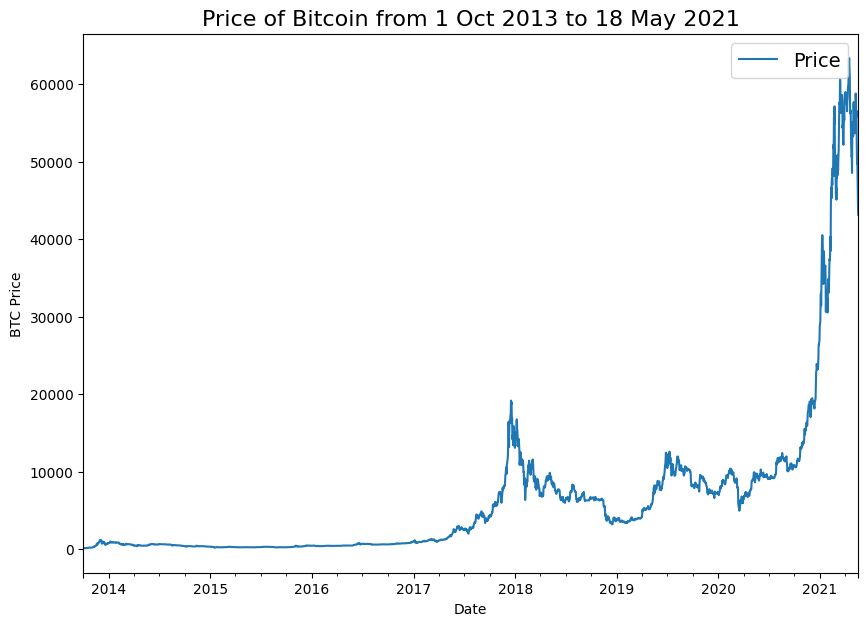

In [ ]:
# Plot past dataset
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

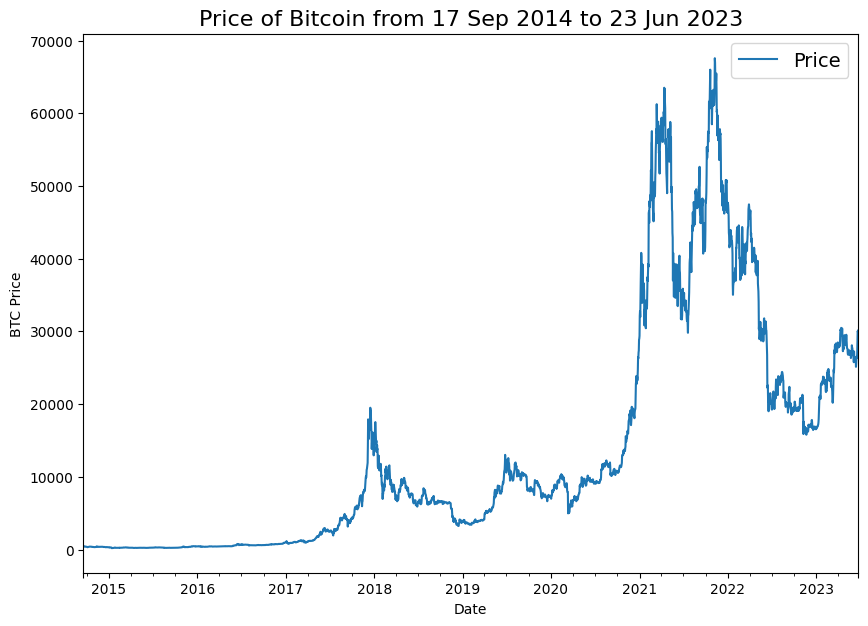

In [ ]:
# Plot new dataset
new_bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 17 Sep 2014 to 23 Jun 2023", fontsize=16)
plt.legend(fontsize=14)

In [ ]:
# Get bitcoin date array
timesteps = new_bitcoin_prices.index.to_numpy()
prices = new_bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [ ]:
# Create a windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3196, 3196)

In [ ]:
# Make train/test splits
X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(X_train), len(X_test), len(y_train), len(y_test)

(2556, 640, 2556, 640)

#### Use the best -- model_1

In [ ]:
tf.random.set_seed(42)

# Construct model
ex_2_model_1 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear")  # linear activation is the same as having no activation
], name="ex_2_model_1")  # give the model a name so we can save it

# Compile model
ex_2_model_1.compile(loss="mae",
                     optimizer=Adam())

In [ ]:
# Fit the model
ex_2_model_1.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(model_name=ex_2_model_1.name)])

In [ ]:
# Load best model and evaluate
ex_2_model_1 = load_model("model_experiments/ex_2_model_1")
ex_2_model_1.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 718.6917


718.6917114257812

In [ ]:
# Make predictions
ex_2_model_1_preds = make_preds(ex_2_model_1, X_test)

20/20 [==============================] - 0s 1ms/step


In [ ]:
# Evaluate predictions
ex_2_model_1_results = evaluate_predictions(y_test, ex_2_model_1_preds)
ex_2_model_1_results

{'mae': 14337.161,
 'mse': 343470340.0,
 'rmse': 17856.537,
 'mape': 49.032692,
 'mase': 20.169046}

In [ ]:
# Compare results with model_1 that trained on past data of Bitcoin
model_1_results

{'mae': 571.6485,
 'mse': 1177253.8,
 'rmse': 1085.0132,
 'mape': 2.55696,
 'mase': 1.0042281}

On the newest data of bitcoin price from the 2023 year, model_1 performs worst than the first model on older data, my guess is that because in the period 2021 - 2022 years, bitcoin has some fall and rise after fall, and in the next period 2022 - 2023 Bitcoin demonstrate significant drop, which may be why the model failed to predict it.

### Exercise - 3

I use the best model -- model_1, and data of newest Bitcoin price from Exercise 2

In [ ]:
# Set hyperparameters
HORIZON = 1
WINDOW_SIZES = np.arange(2, 12, 1)

In [ ]:
# Prepare dictionary for models with their results
model_1_results_dict = {}
model_4_results_dict = {}
model_5_results_dict = {}
model_6_results_dict = {}
model_7_results_dict = {}

In [ ]:
# Prepare dataset with reward_block data
# Block reward values
block_reward_1 = 50  # 3 January 2009 (2009-01-03)
block_reward_2 = 25  # 28 November 2012
block_reward_3 = 12.5  # 9 Jupy 2016
block_reward_4 = 6.25  # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

# Get date indexes for when to add different block dates
block_reward_2_days = (block_reward_3_datetime - new_bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - new_bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

# Add  block_reward column
bitcoin_prices_block = new_bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block-reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


In [ ]:
def window_experiment(window_size, horizon):
    """
    Experiment to test window size on one model.
    """
    tf.random.set_seed(42)

    # Preparing univariate windowed dataset
    # Create windowed dataset
    full_windows, full_labels = make_windows(prices, window_size, horizon)
    # Create train/test splits
    X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels, test_split=0.2)

    # === Collecting results of model_1 ===

    # Construct model
    ex_3_model_1 = Sequential([
        Dense(128, activation="relu"),
        Dense(horizon, activation="linear")  # linear activation is the same as having no activation
    ], name=f"ex_3_model_1_win_{window_size}")  # give the model a name so we can save it

    # Compile model
    ex_3_model_1.compile(loss="mae",
                         optimizer=Adam())

    # Fit the model
    ex_3_model_1.fit(X_train, y_train,
                     batch_size=128,
                     epochs=100,
                     verbose=0,
                     validation_data=(X_test, y_test),
                     callbacks=[create_model_checkpoint(model_name=ex_3_model_1.name)]
                     )

    # Load the best model
    ex_3_model_1 = load_model(f"model_experiments/ex_3_model_1_win_{window_size}")

    # Make predictions
    ex_3_model_1_preds = make_preds(ex_3_model_1, X_test)

    # Evaluate predictions
    ex_3_model_1_results = evaluate_predictions(y_test, ex_3_model_1_preds)

    # Collect results to the dictionary of results
    model_1_results_dict[ex_3_model_1.name] = ex_3_model_1_results

    # === Collecting results of model_4 ===

    # Construct model
    ex_3_model_4 = Sequential([
        Lambda(lambda x: tf.expand_dims(x, axis=1)),
        Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
        Dense(horizon)
    ], name=f"ex_3_model_4_win_{window_size}")

    # Compile model
    ex_3_model_4.compile(loss="mae",
                         optimizer=Adam())

    # Fit the model
    ex_3_model_4.fit(X_train, y_train,
                     batch_size=128,
                     epochs=100,
                     verbose=0,
                     validation_data=(X_test, y_test),
                     callbacks=[create_model_checkpoint(model_name=ex_3_model_4.name)])

    # Load the best model
    ex_3_model_4 = load_model(f"model_experiments/ex_3_model_4_win_{window_size}")

    # Make predictions
    ex_3_model_4_preds = make_preds(ex_3_model_4, X_test)

    # Evaluate preictions
    ex_3_model_4_results = evaluate_predictions(y_test, ex_3_model_4_preds)

    # Collect results to the dictionary of results
    model_4_results_dict[ex_3_model_4.name] = ex_3_model_4_results

    # === Collecting results of moel_5 ===

    # Construct model
    inputs = Input(shape=(int(window_size)))
    x = Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    x = LSTM(128, activation="relu")(x)
    output = Dense(horizon)(x)
    ex_3_model_5 = Model(inputs=inputs, outputs=output, name=f"ex_3_model_5_win_{window_size}")

    # Compile model
    ex_3_model_5.compile(loss="mae",
                         optimizer=Adam())

    # Fit the model
    ex_3_model_5.fit(X_train, y_train,
                     batch_size=128,
                     epochs=100,
                     verbose=0,
                     validation_data=(X_test, y_test),
                     callbacks=[create_model_checkpoint(model_name=ex_3_model_5.name)])

    # Load the best model
    ex_3_model_5 = load_model(f"model_experiments/ex_3_model_5_win_{window_size}")

    # Make predictions
    ex_3_model_5_preds = make_preds(ex_3_model_5, X_test)

    # Evaluate predictions
    ex_3_model_5_results = evaluate_predictions(y_test, ex_3_model_5_preds)

    # Collect results to the dictionary of results
    model_5_results_dict[ex_3_model_5.name] = ex_3_model_5_results

    # === Prepare multivariate dataset ===
    bitcoin_prices_windowed = bitcoin_prices_block.copy()

    # Add windowed columns
    for i in range(window_size):
        bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

    X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
    y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

    split_size = int(len(X) * 0.8)
    X_train, y_train = X[:split_size], y[:split_size]
    X_test, y_test = X[split_size:], y[split_size:]

    # Optimize dataset with tf.data.Dataset class
    # Prepare train & test tf.data.Dataset
    train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
    train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

    test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
    test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

    # Combine windows (features) and labels to entire dataset
    train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
    test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

    # Optimize dataset
    BATCH_SIZE = 1024
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # === Collecting results of model_6

    # Construct model
    ex_3_model_6 = Sequential([
        Dense(128, activation="relu"),
        Dense(horizon)
    ], name=f"ex_3_model_6_win_{window_size}")

    # Compile model
    ex_3_model_6.compile(loss="mae",
                         optimizer=Adam())

    # Fit the model
    ex_3_model_6.fit(train_dataset,
                     batch_size=128,
                     epochs=100,
                     verbose=0,
                     validation_data=test_dataset,
                     callbacks=[create_model_checkpoint(model_name=ex_3_model_6.name)])

    # Load the best model
    ex_3_model_6 = load_model(f"model_experiments/ex_3_model_6_win_{window_size}")

    # Make predictions
    ex_3_model_6_preds = make_preds(ex_3_model_6, test_dataset)

    # Evaluate predictions
    ex_3_model_6_results = evaluate_predictions(y_test, ex_3_model_6_preds)

    # Collect results to the dictionary of results
    model_6_results_dict[ex_3_model_6.name] = ex_3_model_5_results

    # Prepare optimized dataset for model_7
    bitcoin_prices_windowed = new_bitcoin_prices.copy()

    # Add windowed columns
    for i in range(window_size):
        bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

    X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
    y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

    split_size = int(len(X) * 0.8)
    X_train, y_train = X[:split_size], y[:split_size]
    X_test, y_test = X[split_size:], y[split_size:]

    # Optimize dataset with tf.data.Dataset class
    # Prepare train & test tf.data.Dataset
    train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
    train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

    test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
    test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

    # Combine windows (features) and labels to entire dataset
    train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
    test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

    # Optimize dataset
    BATCH_SIZE = 1024
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



    # === Collecting results of model_7

    N_EPOCHS = 5000
    N_NEURONS = 512
    N_LAYERS = 4
    N_STACKS = 30

    INPUT_SIZE = int(window_size) * horizon
    THETA_SIZE = INPUT_SIZE + horizon

    # Construct model
    nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                     theta_size=THETA_SIZE,
                                     horizon=horizon,
                                     n_neurons=N_NEURONS,
                                     n_layers=N_LAYERS,
                                     name="InitialBlock")

    stack_input = Input(shape=(INPUT_SIZE), name="stack_input")
    backcast, forecast = nbeats_block_layer(stack_input)
    residuals = subtract([stack_input, backcast], name="subtract_00")

    for i, _ in enumerate(range(N_STACKS-1)):

        backcast, block_forecast = NBeatsBlock(
            input_size=INPUT_SIZE,
            theta_size=THETA_SIZE,
            horizon=horizon,
            n_neurons=N_NEURONS,
            n_layers=N_LAYERS,
            name=f"NBeatsBlock_{i}"
        )(residuals)

        residuals = subtract([residuals, backcast], name=f"subtract_{i}")
        forecast = add([forecast, block_forecast], name=f"add_{i}")

    # Define model
    ex_3_model_7 = Model(inputs=stack_input,
                         outputs=forecast,
                         name=f"ex_3_model_7_win_{window_size}")

    # Compile model
    ex_3_model_7.compile(loss="mae",
                         optimizer=Adam(0.001),
                         metrics=["mae", "mse"])

    # Create callbacks
    callbacks = [EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)]

    # Fit the model
    ex_3_model_7.fit(train_dataset,
                     epochs=N_EPOCHS,
                     verbose=0,
                     validation_data=test_dataset,
                     callbacks=callbacks)

    # Make predictions
    ex_3_model_7_preds = make_preds(ex_3_model_7, test_dataset)

    # Evaluate predictions
    ex_3_model_7_results = evaluate_predictions(y_test, ex_3_model_7_preds)

    # Collect results to the dictionary of results
    model_7_results_dict[ex_3_model_7.name] = ex_3_model_7_results

    print(f"Training with window size = {window_size} -- Done")

In [ ]:
# Loop through all window sizes for dataset
for window_size in WINDOW_SIZES:
    window_experiment(window_size, HORIZON)

20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 34ms/step

Epoch 267: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 367: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 1s 1s/step
Training with window size = 2 -- Done
20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 35ms/step

Epoch 293: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 393: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 1s 1s/step
Training with window size = 3 -- Done
20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 33ms/step

Epoch 370: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 470: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 1s 1s/step
Training with window size = 4 -- Done
20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 32ms/step

Epoch 277: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 413: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 513: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1/1 [==============================] - 1s 1s/step
Training with window size = 5 -- Done
20/20 [==============================] - 0s 1ms/step


20/20 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 34ms/step

Epoch 256: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 356: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 1s 1s/step
Training with window size = 6 -- Done
20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 31ms/step

Epoch 227: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 374: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 474: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1/1 [==============================] - 1s 1s/step
Training with window size = 7 -- Done
20/20 [==============================] - 0s 1ms/step


20/20 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 33ms/step

Epoch 245: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 345: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 1s 1s/step
Training with window size = 8 -- Done
20/20 [==============================] - 0s 1ms/step


20/20 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 31ms/step

Epoch 250: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 350: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 1s 1s/step
Training with window size = 9 -- Done
20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 32ms/step

Epoch 132: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 368: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1/1 [==============================] - 2s 2s/step
Training with window size = 10 -- Done
20/20 [==============================] - 0s 2ms/step


20/20 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 33ms/step

Epoch 138: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 238: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 1s 1s/step
Training with window size = 11 -- Done


In [ ]:
model_1_results_df = pd.DataFrame(model_1_results_dict).T
model_4_results_df = pd.DataFrame(model_4_results_dict).T
model_5_results_df = pd.DataFrame(model_5_results_dict).T
model_6_results_df = pd.DataFrame(model_6_results_dict).T
model_7_results_df = pd.DataFrame(model_7_results_dict).T

In [ ]:
# View on model_1 reults
model_1_results_df.head(10)

,mae,mse,rmse,mape,mase
ex_3_model_1_win_2,14345.406250,343620896.0,17862.582031,49.051796,20.154482
ex_3_model_1_win_3,14345.587891,343637024.0,17862.722656,49.048973,20.154730
ex_3_model_1_win_4,14359.025391,344288160.0,17886.628906,49.139851,20.173609
ex_3_model_1_win_5,14344.578125,343598848.0,17860.363281,49.033073,20.153316
ex_3_model_1_win_6,14345.559570,343629248.0,17862.335938,49.047024,20.154694
ex_3_model_1_win_7,14339.430664,343623200.0,17857.833984,49.017292,20.173126
ex_3_model_1_win_8,14361.218750,344644288.0,17895.298828,49.163410,20.203781
ex_3_model_1_win_9,14343.199219,343777920.0,17864.867188,49.054470,20.178431
ex_3_model_1_win_10,14357.963867,344480320.0,17890.001953,49.147072,20.199202
ex_3_model_1_win_11,14345.854492,343906528.0,17868.632812,49.062893,20.182165


In [ ]:
# View on model_4 reults
model_4_results_df.head(10)

,mae,mse,rmse,mape,mase
ex_3_model_4_win_2,14342.732422,343483840.0,17858.046875,49.038628,20.150723
ex_3_model_4_win_3,14350.887695,343887200.0,17872.349609,49.089027,20.162182
ex_3_model_4_win_4,14357.208984,344193696.0,17883.349609,49.129440,20.171062
ex_3_model_4_win_5,14353.807617,344023776.0,17876.246094,49.096977,20.166283
ex_3_model_4_win_6,14367.232422,344673952.0,17900.164062,49.189625,20.185146
ex_3_model_4_win_7,14356.408203,344425056.0,17887.300781,49.131451,20.197014
ex_3_model_4_win_8,14350.721680,344154176.0,17877.806641,49.097580,20.189011
ex_3_model_4_win_9,14350.371094,344119424.0,17876.628906,49.095322,20.188517
ex_3_model_4_win_10,14349.256836,344051968.0,17875.000000,49.095356,20.186951
ex_3_model_4_win_11,14349.417969,344069664.0,17875.724609,49.097755,20.187178


In [ ]:
# View on model_5 reults
model_5_results_df.head(10)

,mae,mse,rmse,mape,mase
ex_3_model_5_win_2,14350.101562,343818432.0,17871.136719,49.095760,20.161076
ex_3_model_5_win_3,14340.205078,343356928.0,17853.605469,49.023636,20.147171
ex_3_model_5_win_4,14344.033203,343518720.0,17860.066406,49.053848,20.152550
ex_3_model_5_win_5,14362.814453,344435776.0,17892.191406,49.166283,20.178938
ex_3_model_5_win_6,14372.187500,344896480.0,17908.978516,49.229710,20.192104
ex_3_model_5_win_7,14354.540039,344327360.0,17883.972656,49.121246,20.194382
ex_3_model_5_win_8,14350.907227,344172928.0,17878.767578,49.102146,20.189272
ex_3_model_5_win_9,14335.852539,343445664.0,17850.929688,48.990520,20.168095
ex_3_model_5_win_10,14330.202148,343142880.0,17840.767578,48.960335,20.160141
ex_3_model_5_win_11,14359.769531,344578880.0,17894.154297,49.166245,20.201744


In [ ]:
# View on model_6 reults
model_6_results_df.head(10)

,mae,mse,rmse,mape,mase
ex_3_model_6_win_2,14350.101562,343818432.0,17871.136719,49.095760,20.161076
ex_3_model_6_win_3,14340.205078,343356928.0,17853.605469,49.023636,20.147171
ex_3_model_6_win_4,14344.033203,343518720.0,17860.066406,49.053848,20.152550
ex_3_model_6_win_5,14362.814453,344435776.0,17892.191406,49.166283,20.178938
ex_3_model_6_win_6,14372.187500,344896480.0,17908.978516,49.229710,20.192104
ex_3_model_6_win_7,14354.540039,344327360.0,17883.972656,49.121246,20.194382
ex_3_model_6_win_8,14350.907227,344172928.0,17878.767578,49.102146,20.189272
ex_3_model_6_win_9,14335.852539,343445664.0,17850.929688,48.990520,20.168095
ex_3_model_6_win_10,14330.202148,343142880.0,17840.767578,48.960335,20.160141
ex_3_model_6_win_11,14359.769531,344578880.0,17894.154297,49.166245,20.201744


In [ ]:
# View on model_7 reults
model_7_results_df.head(10)

,mae,mse,rmse,mape,mase
ex_3_model_7_win_2,713.039673,1235749.750,1111.642822,2.181397,1.001780
ex_3_model_7_win_3,713.858398,1244903.000,1115.752197,2.180950,1.002930
ex_3_model_7_win_4,716.319214,1234216.625,1110.953003,2.196709,1.006388
ex_3_model_7_win_5,719.850891,1241293.625,1114.133545,2.203965,1.011349
ex_3_model_7_win_6,722.825500,1261115.500,1122.994019,2.212718,1.015529
ex_3_model_7_win_7,717.845398,1227884.000,1108.099243,2.209715,1.009886
ex_3_model_7_win_8,743.819275,1323706.000,1150.524170,2.270146,1.046427
ex_3_model_7_win_9,752.025452,1344225.000,1159.407104,2.291293,1.057971
ex_3_model_7_win_10,727.559204,1255957.625,1120.695190,2.216133,1.023551
ex_3_model_7_win_11,766.923096,1368732.625,1169.928467,2.335489,1.078930


After all experiments, we see that different window sizes fit with different models, because this is a hyperparameter and, as with all hyperparameters, it needs to be tested with different values to find the best value for one model.

PS. and here we find another answer (for exercise - 2), model_7 (NBeats model) performs best on new data (from 2014 - to 2023).

### Exercise - 4

In [ ]:
# Use Keras built-in function to create time series dataset
from keras.utils import timeseries_dataset_from_array

# Set hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create windows of dataset with built-in function
full_windows = timeseries_dataset_from_array(prices, targets=None,
                                             sequence_length=WINDOW_SIZE,
                                             sequence_stride=1,
                                             sampling_rate=1,
                                             batch_size=None, seed=42)
# Create labels of dataset with built-in function
full_labels = timeseries_dataset_from_array(prices, targets=None,
                                            sequence_length=HORIZON,
                                            sequence_stride=1,
                                            sampling_rate=1,
                                            start_index=WINDOW_SIZE,
                                            batch_size=None, seed=42)

In [ ]:
full_window_17 = list(full_windows.as_numpy_iterator())[17]
full_label_17 = list(full_labels.as_numpy_iterator())[17]

full_window_18 = list(full_windows.as_numpy_iterator())[18]
full_label_18 = list(full_labels.as_numpy_iterator())[18]

In [ ]:
print(f"Window: {full_window_17} predict label: {full_label_17}")
print(f"Window: {full_window_18} predict label: {full_label_18}")

Window: [328.865997 320.51001  330.07901  336.187012 352.940002 365.026001
 361.562012] predict label: [362.299011]
Window: [320.51001  330.07901  336.187012 352.940002 365.026001 361.562012
 362.299011] predict label: [378.549011]


In [ ]:
# Create full datasets
full_dataset = tf.data.Dataset.zip((full_windows, full_labels)).batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create train/test splits
split_size = int(len(full_dataset) * 0.8)
y_test = np.array(list(full_labels.skip(split_size).unbatch().as_numpy_iterator()), dtype=np.float32)
y_test = np.expand_dims(y_test, axis=1)

train_dataset = full_dataset.take(split_size)
test_dataset = full_dataset.skip(split_size)

In [ ]:
# Built model
tf.random.set_seed(42)

# Construct model
ex_4_model_1 = Sequential([
    Input(shape=(WINDOW_SIZE)),
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear")
], name="ex_4_model_1")

# Compile model
ex_4_model_1.compile(loss="mae",
                     optimizer=Adam())

In [ ]:
# Fit the model
ex_4_model_1.fit(train_dataset,
                 epochs=100,
                 verbose=0,
                 validation_data=test_dataset,
                 callbacks=[create_model_checkpoint(model_name=ex_4_model_1.name)])

In [ ]:
# Load best model and evaluate it
ex_4_model_1 = load_model("model_experiments/ex_4_model_1/")
ex_4_model_1.evaluate(test_dataset)

5/5 [==============================] - 0s 17ms/step - loss: 1137.6476


1137.6475830078125

In [ ]:
# Make predictions
ex_4_model_1_preds = make_preds(ex_4_model_1, test_dataset)

5/5 [==============================] - 0s 12ms/step


In [ ]:
# Evaluate predictions and make results of the evaluation
ex_4_model_1_results = evaluate_predictions(y_test, ex_4_model_1_preds)
ex_4_model_1_results

{'mae': 22959.97,
 'mse': 722165060.0,
 'rmse': 26019.016,
 'mape': 2500.8376,
 'mase': 62.960007}

In [ ]:
# Compare results with first model_1 on new data
ex_2_model_1_results

{'mae': 14341.49,
 'mse': 343709800.0,
 'rmse': 17861.459,
 'mape': 49.034763,
 'mase': 20.176027}

In this experiment we see that model_1 on data from keras.utils.timeseries_dataset_from_array() function, performs worst than if we take data from ndarray, and this is interesting because data doesn't changes, it only has a different representation.

### Exercise - 5

I think, I can add "Total Hash Rate (TH/s)" to dataset and watch how that affect the model.

---

Total Hash Rate (TH/s)

The estimated number of terahashes per second the bitcoin network is performing in the last 24 hours.

In [ ]:
# Set hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
import json
import requests
# Load total hash rate data
with open("hash-rate.csv", 'w') as hash_file:

    r = requests.get('https://api.blockchain.info/charts/hash-rate?timespan=all&start=2014-09-17&format=csv&sampled=false')
    hash_file.write("Date,Hash_rate\n")
    hash_file.write(r.text)

In [18]:
# Read hash rate data
hash_rate_df = pd.read_csv("hash-rate.csv",
                           parse_dates=["Date"],
                           index_col=["Date"])
hash_rate_df.head()

,Hash_rate
Date,
2014-09-17,280257.530473
2014-09-18,274326.154167
2014-09-19,240220.740405
2014-09-20,256532.025248
2014-09-21,259497.713401


In [19]:
# Combine data of bitcoin price and hash rate
bitcoin_prices_hash = new_bitcoin_prices.copy()
bitcoin_prices_hash["Hash_rate"] = None
bitcoin_prices_hash["Hash_rate"] = hash_rate_df["Hash_rate"]
bitcoin_prices_hash.head()

,Price,Hash_rate
Date,,
2014-09-17,457.334015,280257.530473
2014-09-18,424.440002,274326.154167
2014-09-19,394.795990,240220.740405
2014-09-20,408.903992,256532.025248
2014-09-21,398.821014,259497.713401


In [20]:
# === Prepare multivariate dataset ===
bitcoin_prices_hash_windowed = bitcoin_prices_hash.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
    bitcoin_prices_hash_windowed[f"Price+{i+1}"] = bitcoin_prices_hash_windowed["Price"].shift(periods=i+1)

In [ ]:
# Create data and labels
X = bitcoin_prices_hash_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_hash_windowed.dropna()["Price"].astype(np.float32)

In [ ]:
# Create train/test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

#### Build multivariate model

In [ ]:
# Construct model
ex_5_model_6 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON)
], name=f"ex_5_model_6")

# Compile model
ex_5_model_6.compile(loss="mae",
                     optimizer=Adam())

In [ ]:
# Fit the model
ex_5_model_6.fit(X_train, y_train,
                 batch_size=128,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(model_name=ex_5_model_6.name)])

In [ ]:
# Load the best model
ex_5_model_6 = load_model(f"model_experiments/ex_5_model_6")

In [ ]:
# Make predictions
ex_5_model_6_preds = make_preds(ex_5_model_6, X_test)

20/20 [==============================] - 0s 1ms/step


In [ ]:
# Evaluate predictions
ex_5_model_6_results = evaluate_predictions(y_test, ex_5_model_6_preds)
ex_5_model_6_results

{'mae': 3402.5483,
 'mse': 15308630.0,
 'rmse': 3912.6245,
 'mape': 11.756289,
 'mase': 4.7865934}

In [ ]:
# Compare with model that trained on same dataset but without hash rate data
ex_2_model_1_results

{'mae': 14337.161,
 'mse': 343470340.0,
 'rmse': 17856.537,
 'mape': 49.032692,
 'mase': 20.169046}

With the new feature "Total Hash rate" we achieve an increasing accuracy level compared with the model from exercise 2 that use the same dataset and model architecture but without the "total hash rate".

### Exercise - 6

In [21]:
# Set hyperparameters
HORIZON = 1
WINDOW_SIZE = 7
INTO_FUTURE = 14

In [25]:
# Prepare entire dataset for model
bitcoin_prices_hash_windowed = bitcoin_prices_hash_windowed.dropna()
X_all = bitcoin_prices_hash_windowed.drop(["Price", "Hash_rate"], axis=1).to_numpy()  # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_hash_windowed.dropna()["Price"].to_numpy()

len(bitcoin_prices_hash_windowed), len(X_all), len(y_all)

(3196, 3196, 3196)

In [26]:
# Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024  # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [27]:
def get_ensemble_models(horizon=HORIZON,
                       train_data=dataset_all,
                       num_iter=10,
                       num_epochs=100,
                       loss_fns=["mae", "mse", "mape"]):
    """
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

    For example, if num_iter=10, a list of 30 trined models will be returned:
    10 * len(["mae", "mse", "mape"]).
    """
    # Make empty list for trained ensemble models
    ensemble_models = []

    # Create num_iter number of models per loss function
    for i in range(num_iter):
        # Build and fit a new model with a different loss function
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

            # Construct a simple model (similar to model_1)
            model = Sequential([
                # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
                # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
                Dense(128, kernel_initializer="he_normal", activation="relu"),
                Dense(128, kernel_initializer="he_normal", activation="relu"),
                Dense(horizon)
            ])

            # Compile simple model with current loss function
            model.compile(loss=loss_function,
                          optimizer=Adam(),
                          metrics=["mae", "mse"])

            # Fit model
            model.fit(train_data,
                      epochs=num_epochs,
                      verbose=0,
                      # Add callbacks to prevent training from going/stalling for too long
                      callbacks=[EarlyStopping(monitor="loss",
                                               patience=200,
                                               restore_best_weights=True),
                                 ReduceLROnPlateau(monitor="loss",
                                                   patience=100,
                                                   verbose=1)])

            # Append fitted model to list of ensemble models
            ensemble_models.append(model)

    return ensemble_models  # return list of trained models

In [28]:
%%time
# Get list of tained ensemble models
ex_6_ensemble_models = get_ensemble_models(num_iter=5,
                                           num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 630: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 450: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 550: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 368: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 712: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 817: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 917: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 116: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 544: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing 

In [100]:
# 1. Createa function to make predictions into the future
def make_ensemble_future_forecast(values, ensemble_models, into_future, window_size=WINDOW_SIZE) -> list:
    """
    Makes future forecasts into_future steps aftre values ends.

    Returns future forecasts as list of floats.
    """
    # 2. Make an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-window_size:]  # only want preds from the last window (this will get updated)

    # 3. Make INTO_FUTURE number of predictions, altering the ata which gets predicted on each time
    for i in range(len(ensemble_models)):
        future_forecast.append([])
        for _ in range(into_future):

            # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
            future_pred = ensemble_models[i].predict(tf.expand_dims(last_window, axis=0), verbose=0)

            # Append predictions to future_forecast
            future_forecast[i].append(tf.squeeze(future_pred).numpy())

            # Update last window with new pred and get window_size most recent preds (model was trained on window_size windows)
            last_window = np.append(last_window, future_pred)[-window_size:]

    return future_forecast

In [101]:
# Make forecasts into future of the price of Bitcoin
future_forecast = make_ensemble_future_forecast(values=y_all,
                                                ensemble_models=ex_6_ensemble_models,
                                                into_future=INTO_FUTURE,
                                                window_size=WINDOW_SIZE)

#### Plot future interval forecast

In [102]:
future_forecast

[[26356.572,
  27478.256,
  28228.75,
  30174.797,
  29828.004,
  30857.885,
  29901.477,
  26529.154,
  27859.895,
  28017.73,
  30330.79,
  29716.89,
  31040.775,
  29372.473],
 [27071.096,
  27666.045,
  28103.488,
  30410.764,
  29751.695,
  30792.203,
  28647.873,
  27592.93,
  27355.824,
  28343.76,
  30281.213,
  29865.164,
  30490.352,
  28225.533],
 [27662.959,
  27354.092,
  28483.912,
  30317.467,
  29946.137,
  30477.037,
  28201.986,
  27741.732,
  27354.078,
  28630.98,
  30355.803,
  30026.768,
  30462.674,
  28186.57],
 [28071.379,
  27760.523,
  28290.586,
  30688.611,
  29902.379,
  30562.965,
  28256.465,
  28191.484,
  28281.152,
  27799.621,
  31035.38,
  29796.975,
  30461.646,
  28498.164],
 [27852.445,
  28886.77,
  27326.43,
  31047.25,
  30358.992,
  29614.887,
  29098.38,
  27383.59,
  29481.219,
  27468.305,
  30113.453,
  31295.027,
  28627.156,
  29638.299],
 [26678.67,
  29836.533,
  27128.52,
  29156.31,
  31177.578,
  27972.287,
  29480.873,
  26025.67,

In [103]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices_hash.index[-1]
last_timestep

Timestamp('2023-06-24 00:00:00')

In [104]:
# Get future dates
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2023-06-25', '2023-06-26', '2023-06-27', '2023-06-28',
       '2023-06-29', '2023-06-30', '2023-07-01', '2023-07-02',
       '2023-07-03', '2023-07-04', '2023-07-05', '2023-07-06',
       '2023-07-07', '2023-07-08'], dtype='datetime64[D]')

In [105]:
# Get the lower and upper bounds of the 95%
lower, upper = get_lower_upper(preds=future_forecast)
lower, upper

(<tf.Tensor: shape=(14,), dtype=float32, numpy=
 array([26211.52 , 25513.959, 25756.219, 28512.275, 27151.422, 26189.861,
        24374.105, 25996.766, 25400.469, 25655.283, 28143.889, 26859.84 ,
        26088.488, 24260.965], dtype=float32)>,
 <tf.Tensor: shape=(14,), dtype=float32, numpy=
 array([28011.266, 29326.299, 31532.488, 31408.33 , 32373.832, 31230.932,
        30253.082, 28265.445, 29507.887, 31791.467, 31581.979, 32578.676,
        31095.238, 30188.738], dtype=float32)>)

In [106]:
# Get the median values of our ensemble preds
future_ensemble_median = np.median(future_forecast, axis=0)

In [107]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_ensemble_median = np.insert(future_ensemble_median, 0, bitcoin_prices_hash.iloc[-1]["Price"])
next_time_steps, future_ensemble_median

(array(['2023-06-24', '2023-06-25', '2023-06-26', '2023-06-27',
        '2023-06-28', '2023-06-29', '2023-06-30', '2023-07-01',
        '2023-07-02', '2023-07-03', '2023-07-04', '2023-07-05',
        '2023-07-06', '2023-07-07', '2023-07-08'], dtype='datetime64[D]'),
 array([30548.695, 27043.646, 27206.338, 28290.586, 29998.668, 29927.908,
        27972.287, 26760.559, 27125.203, 27239.664, 28393.521, 30113.453,
        29865.164, 27857.781, 26589.475], dtype=float32))

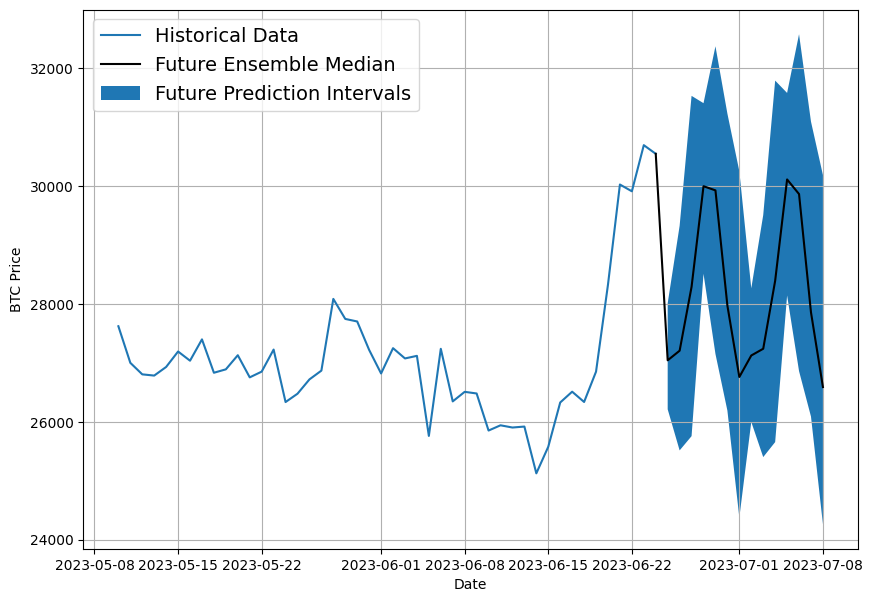

In [108]:
# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
plt.figure(figsize=(10, 7))

plot_time_series(bitcoin_prices_hash_windowed.index, y_all, start=3150, format='-', label="Historical Data")
plot_time_series(next_time_steps, future_ensemble_median, 'k-', label="Future Ensemble Median")

plt.xlabel("Date")
plt.ylabel("BTC Price")

plt.fill_between(next_time_steps[1:],
                 lower, upper, label="Future Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)

Finally, we have results from ensemble models trained on all data for future forecasts and the result that we received is very bad.

### Exercise - 7

We take same data and models from entire dataset for model, but we will retrain model every time after prediction.

In [109]:
# 1. Createa function to make predictions into the future
def make_ensemble_retrained_future_forecast(values, ensemble_models, into_future, window_size=WINDOW_SIZE) -> list:
    """
    Makes future forecasts into_future steps aftre values ends.

    Returns future forecasts as list of floats.
    """
    # 2. Make an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-window_size:]  # only want preds from the last window (this will get updated)

    # 3. Make INTO_FUTURE number of predictions, altering the ata which gets predicted on each time
    for i in range(len(ensemble_models)):
        future_forecast.append([])
        for _ in range(into_future):

            # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
            future_pred = ensemble_models[i].predict(tf.expand_dims(last_window, axis=0), verbose=0)

            # Append predictions to future_forecast
            future_forecast[i].append(tf.squeeze(future_pred).numpy())

            last_window_data = tf.data.Dataset.from_tensor_slices(tf.expand_dims(last_window, axis=0))
            future_pred_data = tf.data.Dataset.from_tensor_slices(future_pred)

            data_for_training = tf.data.Dataset.zip((last_window_data, future_pred_data))

            data_for_training = data_for_training.batch(1).prefetch(tf.data.AUTOTUNE)

            # Exercise for retrain model after prediction
            ensemble_models[i].fit(data_for_training,
                                   epochs=5,
                                   verbose=0)

            # Update last window with new pred and get window_size most recent preds (model was trained on window_size windows)
            last_window = np.append(last_window, future_pred)[-window_size:]

    return future_forecast

In [110]:
%%time
# Make forecasts into future of the price of Bitcoin
retrained_future_forecast = make_ensemble_retrained_future_forecast(values=y_all,
                                                                    ensemble_models=ex_6_ensemble_models,
                                                                    into_future=INTO_FUTURE,
                                                                    window_size=WINDOW_SIZE)

CPU times: user 20.9 s, sys: 1.15 s, total: 22 s
Wall time: 23.2 s


In [111]:
# Get the lower and upper bounds of the 95%
lower, upper = get_lower_upper(preds=retrained_future_forecast)
lower, upper

(<tf.Tensor: shape=(14,), dtype=float32, numpy=
 array([26203.85 , 25482.998, 25743.75 , 28446.97 , 27090.477, 26157.627,
        24310.697, 25980.436, 25371.023, 25640.684, 28078.762, 26798.264,
        26062.65 , 24210.277], dtype=float32)>,
 <tf.Tensor: shape=(14,), dtype=float32, numpy=
 array([27974.756, 29302.986, 31496.582, 31386.615, 32353.652, 31188.303,
        30241.635, 28235.955, 29482.191, 31753.45 , 31559.703, 32551.857,
        31051.58 , 30163.855], dtype=float32)>)

In [112]:
# Get the median values of our ensemble preds
retrained_future_ensemble_median = np.median(retrained_future_forecast, axis=0)

In [113]:
# Insert last timestep/final price so the graph doesn't look messed
retrained_future_ensemble_median = np.insert(retrained_future_ensemble_median, 0, bitcoin_prices_hash.iloc[-1]["Price"])
next_time_steps, retrained_future_ensemble_median

(array(['2023-06-24', '2023-06-25', '2023-06-26', '2023-06-27',
        '2023-06-28', '2023-06-29', '2023-06-30', '2023-07-01',
        '2023-07-02', '2023-07-03', '2023-07-04', '2023-07-05',
        '2023-07-06', '2023-07-07', '2023-07-08'], dtype='datetime64[D]'),
 array([30548.695, 27035.555, 27181.88 , 28261.021, 29943.418, 29888.072,
        27917.781, 26704.924, 27101.828, 27213.963, 28366.04 , 30067.441,
        29816.766, 27813.4  , 26593.363], dtype=float32))

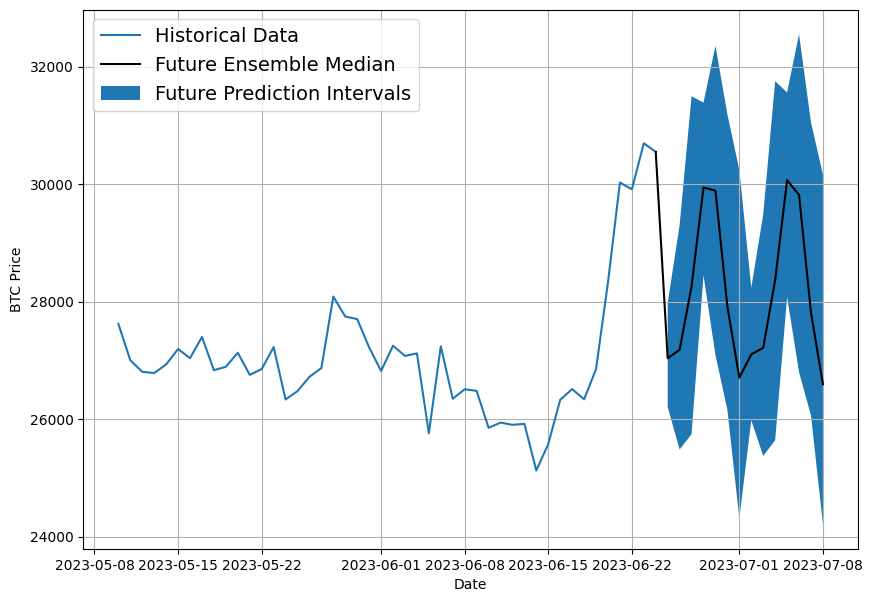

In [114]:
# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
plt.figure(figsize=(10, 7))

plot_time_series(bitcoin_prices_hash_windowed.index, y_all, start=3150, format='-', label="Historical Data")
plot_time_series(next_time_steps, retrained_future_ensemble_median, 'k-', label="Future Ensemble Median")

plt.xlabel("Date")
plt.ylabel("BTC Price")

plt.fill_between(next_time_steps[1:],
                 lower, upper, label="Future Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)

In [115]:
# Compare result from exercise 6
retrained_future_ensemble_median, future_ensemble_median

(array([30548.695, 27035.555, 27181.88 , 28261.021, 29943.418, 29888.072,
        27917.781, 26704.924, 27101.828, 27213.963, 28366.04 , 30067.441,
        29816.766, 27813.4  , 26593.363], dtype=float32),
 array([30548.695, 27043.646, 27206.338, 28290.586, 29998.668, 29927.908,
        27972.287, 26760.559, 27125.203, 27239.664, 28393.521, 30113.453,
        29865.164, 27857.781, 26589.475], dtype=float32))

As we see, the difference between retrained model and without retraining process model is not so big, and on the graph this difference is unseen.

### Exercise - 8

In this exercise, I will use the [kats](https://github.com/facebookresearch/Kats) framework for using some prebuilt algorithms for time series problems.

In [124]:
!pip install -q --upgrade pip

In [127]:
!pip install -q kats

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [120]:
# Import some necessary Class for testing prebuilt model
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

ModuleNotFoundError: ignored

In [ ]:
# Prepare dataset for model
new_bitcoin_prices_ts = TimeSeriesData(new_bitcoin_prices)

In [ ]:
# Create a model parameters instance
params = ProphetParams(seasonality_mode="multiplicative")

In [ ]:
# Create a prophet model instance
prophet_model = ProphetModel(new_bitcoin_prices_ts, params)

In [ ]:
# Fit the model simply by calling model.fit()
prophet_model.fit()

In [ ]:
# Make prediction for next 14 days
prophet_future_forecast = prophet_model.predict(steps=14, freq="DS")

#### Another try with [LinkedIn Greykite](https://github.com/linkedin/greykite)

In [ ]:
!pip install -q greykite

In [6]:
# Import some necessary classes for testing prebuilt model
from greykite.common.data_loader import DataLoader
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum

In [7]:
# Prepare dataset
df = pd.read_csv("BTC-USD.csv",
                 parse_dates=["Date"])

new_bitc_prc_df = pd.DataFrame(df[["Date", "Close"]]).rename(columns={"Close": "Price"}).dropna().drop(index=df.index[-1])
new_bitc_prc_df.tail()

,Date,Price
3198,2023-06-20,28327.488281
3199,2023-06-21,30027.296875
3200,2023-06-22,29912.281250
3201,2023-06-23,30695.468750
3202,2023-06-24,30548.695313


In [8]:
# Define inputs
fcst_df = new_bitc_prc_df.copy()
fcst_config = ForecastConfig(
    metadata_param=MetadataParam(time_col="Date", value_col="Price"),  # Column names in `df`
    model_template=ModelTemplateEnum.AUTO.name,  # AUTO model configuration
    forecast_horizon=14,  # Forecasts 14 steps ahead
    coverage=0.95,  # 95% prediction intervals
)

In [9]:
# Creates forecasts
forecaster = Forecaster()
result = forecaster.run_forecast_config(df=fcst_df, config=fcst_config)

/usr/local/lib/python3.10/dist-packages/greykite/common/time_properties.py:418: UserWarning: `train_end_date` is not provided, or Price column of the provided time series contains null values at the end, or the input `train_end_date` is beyond the last timestamp available. Setting `train_end_date` to the last timestamp with a non-null value (2023-06-24 00:00:00).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/greykite/common/time_properties.py:418: UserWarning: `train_end_date` is not provided, or Price column of the provided time series contains null values at the end, or the input `train_end_date` is beyond the last timestamp available. Setting `train_end_date` to the last timestamp with a non-null value (2023-06-24 00:00:00).
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/greykite/algo/uncertainty/conditional/conf_interval.py:279: UserWarning: Re-constructing `h_mat @ h_mat.T` by `lu_d_sqrt @ lu_d_sqrt.T` has a bigger relative error 0.011310471216289504 than tolerance 1e-08. Falling back to `h_mat` for more accurate variance estimation.
  warnings.warn(f"Re-constructing `h_mat @ h_mat.T` by `lu_d_sqrt @ lu_d_sqrt.T` has a bigger relative error "


In [ ]:
!pip install -q plotly

In [11]:
# Prepare lib for plot forecast
import plotly

In [12]:
# Accesses results
greykite_future_forecast = result.forecast
fig = greykite_future_forecast.plot()
plotly.io.show(fig)

In the result, we get the same performance for future forecasts compared between the prebuilt model from "greykite" framework and the handcrafted model with Keras Framework, and maybe, in my opinion, the prebuilt model has the worse result.